# EEGNet with LSTM

This notebook provides a modified reimplementation of the previously tested CNN-based EEG classifiers:
   - EEGNet by [Lawhern et al](http://iopscience.iop.org/article/10.1088/1741-2552/aace8c/meta).
      - Modifications to make it better suited for short-length windows
      - Memory is added after the "feature extraction" layers, the CNN layers, in the form of a LSTM layer

This notebook works in an offline fashion and uses epochs with a length of 3 seconds.
This epoch starts 1 second before the visual queue was given, includes the 1 second the visual queue was shown and ends 1 second after the visual queue was hidden, totalling 3 seconds.
No baseline correction was performed and the raw EEG data was used.
The effective training and testing are done in a half-second window, starting 0.1 seconds after the start of the visual queue.
A window of 0.5 seconds was chosen as it is a common size for sliding window approaches in online systems.
Some alternatives to this setup were also considered, including one alternative performed for all experiment which uses a long, 1.5 seconds, window.


Instructions on where to get the data are available on [the GitHub repository of the BCI master thesis project](https://www.github.com/pikawika/bci-master-thesis). These instructions are under `bci-master-thesis/code/data/CLA/README.md`. We will use the utility file `bci-master-thesis/code/utils/CLA_dataset.py` to work with this data. The data was stored as FIF files, which are included in [the GitHub repository of the BCI master thesis project](https://www.github.com/pikawika/bci-master-thesis).

<hr><hr>

## Table of Contents

- Checking requirements
   - Correct Anaconda environment
   - Correct module access
   - Correct file access
   - Checking TensorFlow support
- Same subject, same session: EEGNet bidirectional LSTM
   - Results
- Same subject, same session: ShallowConvNet with bidirectional ConvLSTM2D
   - Results

<hr><hr>

## Checking requirements

### Correct Anaconda environment

The `bci-master-thesis` Anaconda environment should be active to ensure proper support. Installation instructions are available on [the GitHub repository of the BCI master thesis project](https://www.github.com/pikawika/bci-master-thesis).

In [1]:
####################################################
# CHECKING FOR RIGHT ANACONDA ENVIRONMENT
####################################################

import os
from platform import python_version
from pathlib import Path
from copy import copy

print(f"Active environment: {os.environ['CONDA_DEFAULT_ENV']}")
print(f"Correct environment: {os.environ['CONDA_DEFAULT_ENV'] == 'bci-master-thesis'}")
print(f"\nPython version: {python_version()}")
print(f"Correct Python version: {python_version() == '3.8.10'}")

Active environment: bci-master-thesis
Correct environment: True

Python version: 3.8.10
Correct Python version: True


<hr>

### Correct module access

The following code block will load in all required modules.

In [2]:
####################################################
# LOADING MODULES
####################################################

# allow reloading of libraries
import importlib

# Load util function file
import sys
sys.path.append('../utils')
import CLA_dataset
import TF_tools
importlib.reload(CLA_dataset)
importlib.reload(TF_tools)

# IO functions
from IPython.utils import io

# Set logging level for MNE before loading MNE
os.environ['MNE_LOGGING_LEVEL'] = 'WARNING'

# Modules tailored for EEG data
import mne; print(f"MNE version (1.0.2 recommended): {mne.__version__}")

# EEGNet model
import EEGNet_with_lstm
from EEGNet_with_lstm import EEGNet_bidirectional_lstm, EEGNet_lstm_1Dconv

# Data manipulation modules
import numpy as np; print(f"Numpy version (1.21.5 recommended): {np.__version__}")
import pandas as pd; print(f"Pandas version (1.4.1 recommended): {pd.__version__}")
import copy

# ML libraries
import sklearn;  print(f"Scikit-learn version (1.0.2 recommended): {sklearn.__version__}")
from sklearn.model_selection import train_test_split
from sklearn.metrics import ConfusionMatrixDisplay, accuracy_score
from sklearn.preprocessing import OneHotEncoder

# Deep Learning libraries
import tensorflow as tf;  print(f"TensorFlow version (2.8.0 recommended): {tf.__version__}")

import keras; print(f"Keras version (2.8.0 recommended): {keras.__version__}")
from keras.callbacks import ModelCheckpoint

# Storing files
import pickle;  print(f"Pickle version (4.0 recommended): {pickle.format_version}")

# Plotting
import matplotlib; print(f"Matplotlib version (3.5.1 recommended): {matplotlib.__version__}")
import matplotlib.pyplot as plt

MNE version (1.0.2 recommended): 1.0.2
Numpy version (1.21.5 recommended): 1.21.5
Pandas version (1.4.1 recommended): 1.4.1
Scikit-learn version (1.0.2 recommended): 1.0.2
TensorFlow version (2.8.0 recommended): 2.8.0
Keras version (2.8.0 recommended): 2.8.0
Pickle version (4.0 recommended): 4.0
Matplotlib version (3.5.1 recommended): 3.5.1


<hr>

### Correct file access

As mentioned, this notebook uses a database provided by [Kaya et al](https://doi.org/10.1038/sdata.2018.211). The CLA dataset in particular. Instructions on where to get the data are available on [the GitHub repository of the BCI master thesis project](https://www.github.com/pikawika/bci-master-thesis). These instructions are under `bci-master-thesis/code/data/CLA/README.md`. The following code block checks if all required files are available.

In [3]:
####################################################
# CHECKING FILE ACCESS
####################################################

# Use util to determine if we have access
print("Full Matlab CLA file access: " + str(CLA_dataset.check_matlab_files_availability()))
print("Full MNE CLA file access: " + str(CLA_dataset.check_mne_files_availability()))

Full Matlab CLA file access: True
Full MNE CLA file access: True


<hr>

### Checking TensorFlow support

If you want to use TensorFlow with GPU acceleration, the below codeblock can help you gather insight.

To launch the tensorboard use the following command in the `paper-notebooks` folder, be sure to have the right environments active:
- Windows: `tensorboard --logdir=./logs/`
- MacOS: `tensorboard --logdir='./logs/'`

In [4]:
TF_tools.check_tf_cpu_gpu_presence()

There are 1 CPUs available under the names:
[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]


There are 1 GPUs available under the names:
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


<hr><hr>

## Same subject, same session: EEGNet bidirectional LSTM 

As discussed in the master's thesis, training and testing a classification system can happen using multiple strategies.
A classifier may be trained on a singular subject, using a singular session and testing on that same session.
This is an over-optimistic testing scenario and has a great risk of overfitting with poor generalisation to new sessions or new subjects but can be an okay baseline test to see if *at least something* can be learned.
Just like we did for the CSP approaches, we do this for the EEGNet model as well.


This experiment works as follows:
   - We use participants with at least three recordings
      - Participants: B, C, E
      - NOTE: participant F has three files provided but one of those files has only three MI classes rather than three, hence it is not considered here
   - We use the last recorded session of each of these participants, thus the one where the participant has the most experience
   - We get epochs of 3 seconds, which includes one second before and after the visual queue
      - We use only a half a second window taking into account the online system will use sliding windows.
      - This window starts at 0.1 seconds after then visual queue and ends at 0.6 seconds after the visual queue
   - We split the data in a train/test dataset with 20% test data balanced over all MI classes
   - We use the parameters for EEGNet as found in the experimental notebook `6-DL-based-classification.ipynb`:
      - We input the raw data, which is not baseline corrected, but multiply it by 1000000 to combat the scaling that MNE does per default.
         - This means that we only use the data from the window, so it is easier adoptable to a live setting.
      - We used the modified EEGNet model with memory provided through the `EEGNet_with_lstm.py` util file with the following settings:
         - nb_classes = 3 (int, number of classes to classify)
         - Chans = 21 (number of channels in the EEG dat)
         - Samples = 100 (number of time points in the EEG data - default: 128)
         - dropoutRate = 0.5 (dropout fraction - default: 0.5)
         - kernLength = 50 (length of temporal convolution in first layer. Suggested: half the sampling rate - default: 64)
         - F1 = 8 (number of temporal filters - default: 8)
         - F2 = 16 (number of pointwise filters - default: 16)
         - D = 2 (number of spatial filters to learn within each temporal convolution - default: 2)
         - norm_rate = 0.25 (Normalisation rate - default: 0.25)
         - dropoutType = 'SpatialDropout2D' (Either SpatialDropout2D or Dropout, passed as a string - default: Dropout)
      - We trained for 1000 epochs due to the increased training time compared to EEGNet and the fast convergence, knowing it would overfit pretty quickly, saving the best model based on best validation accuracy and validation loss (0.25 validation split - equal size as true test split)
   - We record the validation accuracy and loss over time for monitoring the training and test on the seperate test set

In [5]:
####################################################
# MODEL OVERVIEW
####################################################

EEGNet_bidirectional_lstm(
    nb_classes = 3, # int, number of classes to classify. 
    Chans = 21, # number of channels in the EEG data. 
    Samples = 100, # number of time points in the EEG data. (default: 128)
    dropoutRate = 0.5, # dropout fraction. (default: 0.5)
    kernLength = 50, # length of temporal convolution in first layer. Suggested: half the sampling rate. (default: 64)
    F1 = 8, # number of temporal filters. (default: 8)
    F2 = 16, # number of pointwise filters. (default: 16)
    D = 2, # number of spatial filters to learn within each temporal convolution. (default: 2)
    norm_rate = 0.3, # Normalisation rate. (default: 0.25)
    dropoutType = 'SpatialDropout2D', # Either SpatialDropout2D or Dropout, passed as a string. (default: Dropout)
    LSTM_size = 64, # Amount of units in LSTM layer
    ltsm_dropout = 0.6,
    ltsm_l1 = 0.0005,
    ltsm_l2 = 0.0005
).summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 21, 100, 8)        400       
                                                                 
 batch_normalization (BatchN  (None, 21, 100, 8)       32        
 ormalization)                                                   
                                                                 
 depthwise_conv2d (Depthwise  (None, 1, 100, 16)       336       
 Conv2D)                                                         
                                                                 
 batch_normalization_1 (Batc  (None, 1, 100, 16)       64        
 hNormalization)                                                 
                                                                 
 activation (Activation)     (None, 1, 100, 16)        0         
                                                        

In [6]:
####################################################
# TRAINING EEGNET FOR EACH SUBJECT AND SESSION
####################################################

# Configure global parameters for all experiments
subject_ids_to_test = ["B", "C", "E"] # Subjects with three recordings
start_offset = -1 # One second before visual queue
end_offset = 1 # One second after visual queue
baseline = None # Baseline correction using data before the visual queue

do_experiment = False # Long experiment disabled per default

# Create the TensorFlow Keras model
keras_eegnet_bidirectional_lstm_model = EEGNet_bidirectional_lstm(
    nb_classes = 3, # int, number of classes to classify. 
    Chans = 21, # number of channels in the EEG data. 
    Samples = 100, # number of time points in the EEG data. (default: 128)
    dropoutRate = 0.5, # dropout fraction. (default: 0.5)
    kernLength = 50, # length of temporal convolution in first layer. Suggested: half the sampling rate. (default: 64)
    F1 = 8, # number of temporal filters. (default: 8)
    F2 = 16, # number of pointwise filters. (default: 16)
    D = 2, # number of spatial filters to learn within each temporal convolution. (default: 2)
    norm_rate = 0.3, # Normalisation rate. (default: 0.25)
    dropoutType = 'SpatialDropout2D', # Either SpatialDropout2D or Dropout, passed as a string. (default: Dropout)
    LSTM_size = 64, # Amount of units in LSTM layer
    ltsm_dropout = 0.6,
    ltsm_l1 = 0.0005,
    ltsm_l2 = 0.0005
        )

if do_experiment:
        # Loop over all subjects and perform the grid search for finding the best parameters
        for subject_id in subject_ids_to_test:
                print("")
                print("####################################################")
                print(f"# TRAINING FOR SUBJECT {subject_id}")
                print("####################################################")
                print("")
                ###################### PREPARE DATA ######################
                
                with io.capture_output():
                        # Get MNE raw object for latest recording of that subject
                        mne_raw = CLA_dataset.get_last_raw_mne_data_for_subject(subject_id= subject_id)
                        
                        # Get epochs for that MNE raw
                        mne_epochs = CLA_dataset.get_usefull_epochs_from_raw(mne_raw,
                                                                             start_offset= start_offset,
                                                                             end_offset= end_offset,
                                                                             baseline= baseline)
                        
                        # Only keep epochs from the MI tasks
                        mne_epochs = mne_epochs['task/neutral', 'task/left', 'task/right']
                        
                        # Load epochs into memory
                        mne_epochs.load_data()
                
                # Get the labels
                labels = mne_epochs.events[:, -1]
                
                # Convert the labels to OHE labels as needed for Keras
                labels = labels.reshape(-1, 1)
                ohe = OneHotEncoder()
                labels = ohe.fit_transform(labels).toarray()
                
                # Get a half second window
                mne_epochs_data = mne_epochs.get_data(tmin= 0.1, tmax= 0.6)
                
                # Fix scaling sensitivity as MNE stores as data * 10e-6
                mne_epochs_data = mne_epochs_data * 1000000
                
                # Create a test and train split
                X_train, X_test, y_train, y_test = train_test_split(mne_epochs_data,
                                                                    labels,
                                                                    test_size = 0.2,
                                                                    shuffle= True,
                                                                    stratify= labels,                                                    
                                                                    random_state= 1998)
                
                # Store the train and test data so the best model can be retrained later
                with open(f"saved_variables/7/EEGNet_lstm/samesubject_samesession/subject{subject_id}/testdata-x.pickle", 'wb') as file:
                        pickle.dump(X_test, file)
                with open(f"saved_variables/7/EEGNet_lstm/samesubject_samesession/subject{subject_id}/testdata-y.pickle", 'wb') as file:
                        pickle.dump(y_test, file)
                with open(f"saved_variables/7/EEGNet_lstm/samesubject_samesession/subject{subject_id}/traindata-x.pickle", 'wb') as file:
                        pickle.dump(X_train, file)
                with open(f"saved_variables/7/EEGNet_lstm/samesubject_samesession/subject{subject_id}/traindata-y.pickle", 'wb') as file:
                        pickle.dump(y_train, file)
                        
                # Store the OHE encoder to enable same conversion later
                with open(f"saved_variables/7/EEGNet_lstm/samesubject_samesession/subject{subject_id}/ohe-encoder.pickle", 'wb') as file:
                        pickle.dump(ohe, file)
                        
                print(f"Shape of all data (epochs, channels, samples): {np.shape(mne_epochs_data)}")
                print(f"Shape of train data (epochs, channels, samples): {np.shape(X_train)}")
                print(f"Shape of test data (epochs, channels, samples): {np.shape(X_test)}")
                
                
                ###################### PREPARE MODEL ######################
                
                # Names for model
                best_base_model_filename = f"saved_variables/7/EEGNet_lstm/samesubject_samesession/subject{subject_id}/trained_model" 
                tensorboard_name = f"paper-notebook7_eegnetlstm_singlesession_subject{subject_id}" # log name for tensorboard
                
                # Create copy of the model that needs training
                trained_model = keras.models.clone_model(keras_eegnet_bidirectional_lstm_model)
                
                # Compile the model so it can be fitted (loss and optimizer from EEGNet paper)
                trained_model.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics=["accuracy"])
                
                # Train model with GPU
                # NOTE: change GPU to CPU if no GPU present
                with tf.device('/gpu:0'):
                        history = trained_model.fit(
                                x= X_train,
                                y= y_train,
                                batch_size= 128, # Default: 32
                                epochs= 1000, # Default: 500 (EEGNet paper)
                                verbose= 1, # 0 = silent, 1 = progress bar, 2 = one line per epoch
                                callbacks= [TF_tools.tensorboard_callback(log_name= tensorboard_name),
                                            TF_tools.lowest_loss_model_save_callback(filepath= best_base_model_filename),
                                            TF_tools.highest_accuracy_model_save_callback(filepath= best_base_model_filename)],
                                validation_split= 0.25,
                                shuffle= True,
                                sample_weight= None, # Can be interesting due to time series
                                use_multiprocessing=True, # Done for faster speed
                                workers= 4 # Done for faster speed
                                )
                        
                # Store the fitting history
                with open(f"saved_variables/7/EEGNet_lstm/samesubject_samesession/subject{subject_id}/fitting_history.pickle", 'wb') as file:
                        pickle.dump(history.history, file)
                
                # Delete vars after singular experiment
                del mne_raw
                del mne_epochs
                del mne_epochs_data
                del trained_model
                del best_base_model_filename
                del tensorboard_name
                del labels
                del file
                del history
                del X_train
                del X_test
                del ohe
                del y_train
                del y_test
    
        # Delete vars after all experiments
        del subject_id
        
# Del global vars
del subject_ids_to_test
del baseline
del do_experiment
del end_offset
del start_offset
del keras_eegnet_bidirectional_lstm_model

#### Results

EEGNet: 

| **Subject** | **EEGNet: best validation accuracy** | **EEGNet: best validation loss** | **EEGNet: test split accuracy (best acc model)** | **EEGNet: test split accuracy (best loss model)** |
|-------------|--------------------------------------|----------------------------------|--------------------------------------------------|---------------------------------------------------|
| B           | 0.8333 @ epoch 1262                  | 0.4747 @ epoch 1959              | 0.7656                                           | 0.7708                                            |
| C           | 0.9167 @ epoch 2497                  | 0.3088 @ epoch 1653              | 0.8906                                           | 0.8906                                            |
| E           | 0.9215 @ epoch 1010                  | 0.2724 @ epoch 981               | 0.8586                                           | 0.8691                                            |

EEGNet with biderectional LSTM:

| **Subject** | **EEGNet LSTM: best validation accuracy** | **EEGNet LSTM: best validation loss** | **EEGNet LSTM: test split accuracy (best acc model)** | **EEGNet LSTM: test split accuracy (best loss model)** |
|-------------|-------------------------------------------|---------------------------------------|-------------------------------------------------------|--------------------------------------------------------|
| B           | 0.8021 @ epoch 75                         | 0.5685 @ epoch 170                    | 0.7083                                                | 0.7135                                                 |
| C           | 0.901 @ epoch 301                         | 0.3569 @ epoch 376                    | 0.9062                                                | 0.8958                                                 |
| E           | 0.9058 @ epoch 478                        | 0.3463 @ epoch 400                    | 0.8272                                                | 0.8272                                                 |

With comparable results it is clear that the extension didn't yield improvements nor caused any major issues.
This might suggest that there is just not more information in the data since all results from all these complex models are so comparable for this experiment type.
One noticeable thing is that there is a far greater chance on overfitting, requiring far more extreme dropout.
This is to be expected given the amount of trainable parameters is increased in such an extreme manner.
However, the experiment setup stores both the model with the best validation accuracy and best loss accuracy, so the final obtained models are not really influenced by overfitting behaviour.
The longer windows might aid in reducing this overfitting phenomenon due to the greater amount of data.

The training plots for the validation scores are given below.
B is dark blue, C is light blue and E is light green.


![Accuracy plot](figures/7/EEGNet_lstm/samesubject_samesession/accuracy.png)
![Loss plot](figures/7/EEGNet_lstm/samesubject_samesession/loss.png)


####################################################
# RESULTS FOR SUBJECT B
####################################################

#### results of training ####
Best training accuracy (max) 0.9045 @ epoch 858
Best training loss (min) 0.3362 @ epoch 997

Best validation accuracy (max) 0.8021 @ epoch 75
Best validation loss (min) 0.5685 @ epoch 170

#### results for highest accuracy model ####
Accuracy of: 0.7083


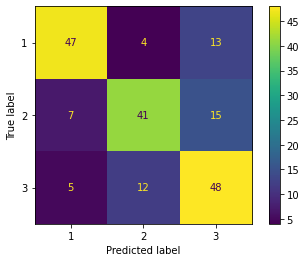


#### results for lowest loss model ####
Accuracy of: 0.7135


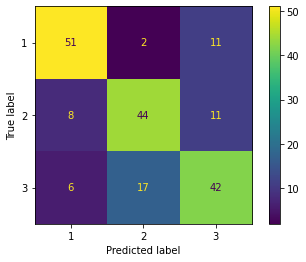


####################################################
# RESULTS FOR SUBJECT C
####################################################

#### results of training ####
Best training accuracy (max) 0.9635 @ epoch 935
Best training loss (min) 0.1744 @ epoch 950

Best validation accuracy (max) 0.901 @ epoch 301
Best validation loss (min) 0.3569 @ epoch 376

#### results for highest accuracy model ####
Accuracy of: 0.9062


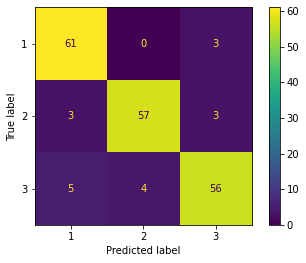


#### results for lowest loss model ####
Accuracy of: 0.8958


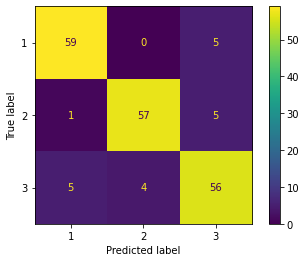


####################################################
# RESULTS FOR SUBJECT E
####################################################

#### results of training ####
Best training accuracy (max) 0.9302 @ epoch 929
Best training loss (min) 0.2418 @ epoch 982

Best validation accuracy (max) 0.9058 @ epoch 478
Best validation loss (min) 0.3463 @ epoch 400

#### results for highest accuracy model ####
Accuracy of: 0.8272


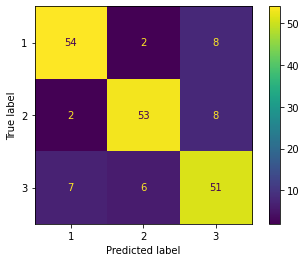


#### results for lowest loss model ####
Accuracy of: 0.8272


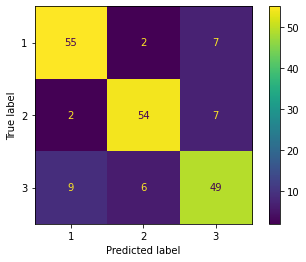

In [7]:
####################################################
# RESULTS
####################################################

# Configure global parameters for all experiments
subject_ids_to_test = ["B", "C", "E"] # Subjects with three recordings

# Loop over all found results
for subject_id in subject_ids_to_test:
    print()
    print("####################################################")
    print(f"# RESULTS FOR SUBJECT {subject_id}")
    print("####################################################")
    print()
    
    ################### load data ###################
    # Names for model
    best_base_model_filename = f"saved_variables/7/EEGNet_lstm/samesubject_samesession/subject{subject_id}/trained_model"
    
    # Open models from file
    lowest_loss_model = TF_tools.load_lowest_loss_model(filepath= best_base_model_filename)
    highest_accuracy_model = TF_tools.load_highest_accuracy_model(filepath= best_base_model_filename)
    
    # Get data from files
    with open(f"saved_variables/7/EEGNet_lstm/samesubject_samesession/subject{subject_id}/testdata-x.pickle", 'rb') as f:
        X_test = pickle.load(f)
    with open(f"saved_variables/7/EEGNet_lstm/samesubject_samesession/subject{subject_id}/testdata-y.pickle", 'rb') as f:
        y_test = pickle.load(f)
        
    # Get OHE from file
    with open(f"saved_variables/7/EEGNet_lstm/samesubject_samesession/subject{subject_id}/ohe-encoder.pickle", 'rb') as f:
        ohe = pickle.load(f)
        
    # Get history from file
    with open(f"saved_variables/7/EEGNet_lstm/samesubject_samesession/subject{subject_id}/fitting_history.pickle", 'rb') as f:
        history = pickle.load(f)
        
    # Convert OHE labels back to true labels
    y_test = ohe.inverse_transform(y_test)
    
    ################### history stats ###################
    print("#### results of training ####")
    print(f"Best training accuracy (max) {np.round(np.max(history['accuracy']), 4)} @ epoch {np.argmax(history['accuracy']) + 1}")
    print(f"Best training loss (min) {np.round(np.min(history['loss']), 4)} @ epoch {np.argmin(history['loss']) + 1}")
    print()
    print(f"Best validation accuracy (max) {np.round(np.max(history['val_accuracy']), 4)} @ epoch {np.argmax(history['val_accuracy']) + 1}")
    print(f"Best validation loss (min) {np.round(np.min(history['val_loss']), 4)} @ epoch {np.argmin(history['val_loss']) + 1}")
    
    ################### highest accuracy model ###################
    print("\n#### results for highest accuracy model ####")
    # Get predictions from lowest loss model and convert back to labels
    y_pred = highest_accuracy_model.predict(X_test)
    y_pred = ohe.inverse_transform(y_pred)
    
    # Get accuracy score and print it
    accuracy =  accuracy_score(y_test, y_pred)
    print(f"Accuracy of: {np.round(accuracy, 4)}")
    
    # Show CM
    ConfusionMatrixDisplay.from_predictions(y_true= y_test, y_pred= y_pred)
    plt.show()
    
    ################### lowest loss model ###################
    print("\n#### results for lowest loss model ####")
    # Get predictions from lowest loss model and convert back to labels
    y_pred = lowest_loss_model.predict(X_test)
    y_pred = ohe.inverse_transform(y_pred)
    
    # Get accuracy score and print it
    accuracy =  accuracy_score(y_test, y_pred)
    print(f"Accuracy of: {np.round(accuracy, 4)}")
    
    # Show CM
    ConfusionMatrixDisplay.from_predictions(y_true= y_test, y_pred= y_pred)
    plt.show()
    
    ################### cleanup ###################
    # remove unused vars
    del best_base_model_filename
    del lowest_loss_model
    del highest_accuracy_model
    del f
    del X_test
    del y_test
    del history
    del ohe
    del y_pred
    del accuracy

# Remove unsused variables
del subject_ids_to_test
del subject_id

<hr><hr>

## Same subject, same session: ShallowConvNet with bidirectional ConvLSTM2D

As discussed in the master's thesis, training and testing a classification system can happen using multiple strategies.
A classifier may be trained on a singular subject, using a singular session and testing on that same session.
This is an over-optimistic testing scenario and has a great risk of overfitting with poor generalisation to new sessions or new subjects but can be an okay baseline test to see if *at least something* can be learned.
Just like we did for the CSP approaches, we do this for the EEGNet model as well.


This experiment works as follows:
   - We use participants with at least three recordings
      - Participants: B, C, E
      - NOTE: participant F has three files provided but one of those files has only three MI classes rather than three, hence it is not considered here
   - We use the last recorded session of each of these participants, thus the one where the participant has the most experience
   - We get epochs of 3 seconds, which includes one second before and after the visual queue
      - We use only a half a second window taking into account the online system will use sliding windows.
      - This window starts at 0.1 seconds after then visual queue and ends at 0.6 seconds after the visual queue
   - We split the data in a train/test dataset with 20% test data balanced over all MI classes
   - We use the parameters for EEGNet as found in the experimental notebook `6-DL-based-classification.ipynb`:
      - We input the raw data, which is not baseline corrected, but multiply it by 1000000 to combat the scaling that MNE does per default.
         - This means that we only use the data from the window, so it is easier adoptable to a live setting.
      - We used the modified EEGNet model with memory provided through the `EEGNet_with_lstm.py` util file with the following settings:
         - nb_classes = 3 (int, number of classes to classify)
         - Chans = 21 (number of channels in the EEG dat)
         - Samples = 100 (number of time points in the EEG data - default: 128)
         - dropoutRate = 0.5 (dropout fraction - default: 0.5)
         - kernLength = 50 (length of temporal convolution in first layer. Suggested: half the sampling rate - default: 64)
         - F1 = 8 (number of temporal filters - default: 8)
         - F2 = 16 (number of pointwise filters - default: 16)
         - D = 2 (number of spatial filters to learn within each temporal convolution - default: 2)
         - norm_rate = 0.25 (Normalisation rate - default: 0.25)
         - dropoutType = 'SpatialDropout2D' (Either SpatialDropout2D or Dropout, passed as a string - default: Dropout)
      - We trained for 500 epochs due to the increased training time, saving the best model based on best validation accuracy and validation loss (0.25 validation split - equal size as true test split)
   - We record the validation accuracy and loss over time for monitoring the training and test on the seperate test set

In [17]:
EEGNet_lstm_1Dconv(
    nb_classes = 3, # int, number of classes to classify. 
    Chans = 21, # number of channels in the EEG data. 
    Samples = 100, # number of time points in the EEG data. (default: 128)
    dropoutRate = 0.5, # dropout fraction. (default: 0.5)
    kernLength = 50, # length of temporal convolution in first layer. Suggested: half the sampling rate. (default: 64)
    F1 = 8, # number of temporal filters. (default: 8)
    D = 2, # number of spatial filters to learn within each temporal convolution. (default: 2)
    norm_rate = 0.25, # Normalisation rate. (default: 0.25)
    dropoutType = 'SpatialDropout2D', # Either SpatialDropout2D or Dropout, passed as a string. (default: Dropout)
    lstm_filters = 40, # Amount of filters for LSTM layer Conv1D. Default: 32
    lstm_kernel_size = 9, # Kernels size for LSTM layer Conv1D.
    ltsm_dropout= 0.7,
    ltsm_l1 = 0.00005, ltsm_l2 = 0.0005
).summary()

Model: "model_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_12 (InputLayer)       [(None, 21, 100, 1)]      0         
                                                                 
 conv2d_11 (Conv2D)          (None, 21, 100, 8)        400       
                                                                 
 batch_normalization_24 (Bat  (None, 21, 100, 8)       32        
 chNormalization)                                                
                                                                 
 depthwise_conv2d_11 (Depthw  (None, 1, 100, 16)       336       
 iseConv2D)                                                      
                                                                 
 batch_normalization_25 (Bat  (None, 1, 100, 16)       64        
 chNormalization)                                                
                                                           

In [18]:
####################################################
# TRAINING EEGNET FOR EACH SUBJECT AND SESSION
####################################################

# Configure global parameters for all experiments
subject_ids_to_test = ["B", "C", "E"] # Subjects with three recordings
start_offset = -1 # One second before visual queue
end_offset = 1 # One second after visual queue
baseline = None # Baseline correction using data before the visual queue

do_experiment = True # Long experiment disabled per default

# Create the TensorFlow Keras model
keras_eegnet_lstm_1Dconv_model = EEGNet_lstm_1Dconv(
    nb_classes = 3, # int, number of classes to classify. 
    Chans = 21, # number of channels in the EEG data. 
    Samples = 100, # number of time points in the EEG data. (default: 128)
    dropoutRate = 0.5, # dropout fraction. (default: 0.5)
    kernLength = 50, # length of temporal convolution in first layer. Suggested: half the sampling rate. (default: 64)
    F1 = 8, # number of temporal filters. (default: 8)
    D = 2, # number of spatial filters to learn within each temporal convolution. (default: 2)
    norm_rate = 0.25, # Normalisation rate. (default: 0.25)
    dropoutType = 'SpatialDropout2D', # Either SpatialDropout2D or Dropout, passed as a string. (default: Dropout)
    lstm_filters = 40, # Amount of filters for LSTM layer Conv1D. Default: 32
    lstm_kernel_size = 9, # Kernels size for LSTM layer Conv1D.
    ltsm_dropout= 0.7,
    ltsm_l1 = 0.00005, ltsm_l2 = 0.0005
)

if do_experiment:
        # Loop over all subjects and perform the grid search for finding the best parameters
        for subject_id in subject_ids_to_test:
                print("")
                print("####################################################")
                print(f"# TRAINING FOR SUBJECT {subject_id}")
                print("####################################################")
                print("")
                ###################### PREPARE DATA ######################
                
                with io.capture_output():
                        # Get MNE raw object for latest recording of that subject
                        mne_raw = CLA_dataset.get_last_raw_mne_data_for_subject(subject_id= subject_id)
                        
                        # Get epochs for that MNE raw
                        mne_epochs = CLA_dataset.get_usefull_epochs_from_raw(mne_raw,
                                                                             start_offset= start_offset,
                                                                             end_offset= end_offset,
                                                                             baseline= baseline)
                        
                        # Only keep epochs from the MI tasks
                        mne_epochs = mne_epochs['task/neutral', 'task/left', 'task/right']
                        
                        # Load epochs into memory
                        mne_epochs.load_data()
                
                # Get the labels
                labels = mne_epochs.events[:, -1]
                
                # Convert the labels to OHE labels as needed for Keras
                labels = labels.reshape(-1, 1)
                ohe = OneHotEncoder()
                labels = ohe.fit_transform(labels).toarray()
                
                # Get a half second window
                mne_epochs_data = mne_epochs.get_data(tmin= 0.1, tmax= 0.6)
                
                # Fix scaling sensitivity as MNE stores as data * 10e-6
                mne_epochs_data = mne_epochs_data * 1000000
                
                # Create a test and train split
                X_train, X_test, y_train, y_test = train_test_split(mne_epochs_data,
                                                                    labels,
                                                                    test_size = 0.2,
                                                                    shuffle= True,
                                                                    stratify= labels,                                                    
                                                                    random_state= 1998)
                
                
                
                # Store the train and test data so the best model can be retrained later
                with open(f"saved_variables/7/EEGNet_lstmconv1D/samesubject_samesession/subject{subject_id}/testdata-x.pickle", 'wb') as file:
                        pickle.dump(X_test, file)
                with open(f"saved_variables/7/EEGNet_lstmconv1D/samesubject_samesession/subject{subject_id}/testdata-y.pickle", 'wb') as file:
                        pickle.dump(y_test, file)
                with open(f"saved_variables/7/EEGNet_lstmconv1D/samesubject_samesession/subject{subject_id}/traindata-x.pickle", 'wb') as file:
                        pickle.dump(X_train, file)
                with open(f"saved_variables/7/EEGNet_lstmconv1D/samesubject_samesession/subject{subject_id}/traindata-y.pickle", 'wb') as file:
                        pickle.dump(y_train, file)
                        
                # Store the OHE encoder to enable same conversion later
                with open(f"saved_variables/7/EEGNet_lstmconv1D/samesubject_samesession/subject{subject_id}/ohe-encoder.pickle", 'wb') as file:
                        pickle.dump(ohe, file)
                        
                print(f"Shape of all data (epochs, channels, samples): {np.shape(mne_epochs_data)}")
                print(f"Shape of train data (epochs, channels, samples): {np.shape(X_train)}")
                print(f"Shape of test data (epochs, channels, samples): {np.shape(X_test)}")
                
                
                ###################### PREPARE MODEL ######################
                
                # Names for model
                best_base_model_filename = f"saved_variables/7/EEGNet_lstmconv1D/samesubject_samesession/subject{subject_id}/trained_model" 
                tensorboard_name = f"paper-notebook7_eegnetlstmconv_singlesession_subject{subject_id}" # log name for tensorboard
                
                # Create copy of the model that needs training
                # Create copy of the model that needs training
                trained_model = keras.models.clone_model(keras_eegnet_lstm_1Dconv_model)
                
                # Compile the model so it can be fitted (loss and optimizer from ShallowConvNet paper)
                trained_model.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics=["accuracy"])
                
                # Train model with GPU
                # NOTE: change GPU to CPU if no GPU present
                with tf.device('/gpu:0'):
                        history = trained_model.fit(
                                x= X_train,
                                y= y_train,
                                batch_size= 128, # Default: 32
                                epochs= 500, # Default: 500 (EEGNet paper)
                                verbose= 1, # 0 = silent, 1 = progress bar, 2 = one line per epoch
                                callbacks= [TF_tools.tensorboard_callback(log_name= tensorboard_name),
                                            TF_tools.lowest_loss_model_save_callback(filepath= best_base_model_filename),
                                            TF_tools.highest_accuracy_model_save_callback(filepath= best_base_model_filename)],
                                validation_split= 0.25,
                                shuffle= True,
                                sample_weight= None, # Can be interesting due to time series
                                use_multiprocessing=True, # Done for faster speed
                                workers= 4 # Done for faster speed
                                )
                        
                # Store the fitting history
                with open(f"saved_variables/7/EEGNet_lstmconv1D/samesubject_samesession/subject{subject_id}/fitting_history.pickle", 'wb') as file:
                        pickle.dump(history.history, file)
                
                # Delete vars after singular experiment
                del mne_raw
                del mne_epochs
                del mne_epochs_data
                del trained_model
                del best_base_model_filename
                del tensorboard_name
                del labels
                del file
                del history
                del X_train
                del X_test
                del ohe
                del y_train
                del y_test
    
        # Delete vars after all experiments
        del subject_id
        
# Del global vars
del subject_ids_to_test
del baseline
del do_experiment
del end_offset
del start_offset
del keras_eegnet_lstm_1Dconv_model


####################################################
# TRAINING FOR SUBJECT B
####################################################

Shape of all data (epochs, channels, samples): (960, 21, 100)
Shape of train data (epochs, channels, samples): (768, 21, 100)
Shape of test data (epochs, channels, samples): (192, 21, 100)
Epoch 1/500
5/5 [==============================] - ETA: 0s - loss: 1.0982 - accuracy: 0.3750
Epoch 1: val_loss improved from inf to 1.07664, saving model to saved_variables/7/EEGNet_lstmconv1D/samesubject_samesession/subjectB\trained_model_lowest_loss_model.hdf5

Epoch 1: val_accuracy improved from -inf to 0.43229, saving model to saved_variables/7/EEGNet_lstmconv1D/samesubject_samesession/subjectB\trained_model_highest_acc_model.hdf5
5/5 [==============================] - 30s 5s/step - loss: 1.0982 - accuracy: 0.3750 - val_loss: 1.0766 - val_accuracy: 0.4323
Epoch 2/500
5/5 [==============================] - ETA: 0s - loss: 1.0794 - accuracy: 0.4549
Epoch 2: val_loss i


Epoch 17: val_accuracy improved from 0.58854 to 0.59896, saving model to saved_variables/7/EEGNet_lstmconv1D/samesubject_samesession/subjectB\trained_model_highest_acc_model.hdf5
5/5 [==============================] - 21s 4s/step - loss: 0.9081 - accuracy: 0.5660 - val_loss: 0.8881 - val_accuracy: 0.5990
Epoch 18/500
5/5 [==============================] - ETA: 0s - loss: 0.8844 - accuracy: 0.6094
Epoch 18: val_loss did not improve from 0.88810

Epoch 18: val_accuracy did not improve from 0.59896
5/5 [==============================] - 21s 4s/step - loss: 0.8844 - accuracy: 0.6094 - val_loss: 0.8885 - val_accuracy: 0.5938
Epoch 19/500
5/5 [==============================] - ETA: 0s - loss: 0.8760 - accuracy: 0.6181
Epoch 19: val_loss did not improve from 0.88810

Epoch 19: val_accuracy did not improve from 0.59896
5/5 [==============================] - 20s 4s/step - loss: 0.8760 - accuracy: 0.6181 - val_loss: 0.8975 - val_accuracy: 0.5990
Epoch 20/500
5/5 [==============================]

5/5 [==============================] - 20s 4s/step - loss: 0.7821 - accuracy: 0.6493 - val_loss: 0.6987 - val_accuracy: 0.7552
Epoch 37/500
5/5 [==============================] - ETA: 0s - loss: 0.7099 - accuracy: 0.7170
Epoch 37: val_loss did not improve from 0.69875

Epoch 37: val_accuracy did not improve from 0.75521
5/5 [==============================] - 22s 4s/step - loss: 0.7099 - accuracy: 0.7170 - val_loss: 0.7165 - val_accuracy: 0.7031
Epoch 38/500
5/5 [==============================] - ETA: 0s - loss: 0.7868 - accuracy: 0.6649
Epoch 38: val_loss did not improve from 0.69875

Epoch 38: val_accuracy did not improve from 0.75521
5/5 [==============================] - 20s 4s/step - loss: 0.7868 - accuracy: 0.6649 - val_loss: 0.7666 - val_accuracy: 0.6771
Epoch 39/500
5/5 [==============================] - ETA: 0s - loss: 0.7797 - accuracy: 0.6684
Epoch 39: val_loss did not improve from 0.69875

Epoch 39: val_accuracy did not improve from 0.75521
5/5 [=============================

Epoch 61/500
5/5 [==============================] - ETA: 0s - loss: 0.6493 - accuracy: 0.7413
Epoch 61: val_loss did not improve from 0.64908

Epoch 61: val_accuracy did not improve from 0.75521
5/5 [==============================] - 23s 5s/step - loss: 0.6493 - accuracy: 0.7413 - val_loss: 0.6637 - val_accuracy: 0.7135
Epoch 62/500
5/5 [==============================] - ETA: 0s - loss: 0.6794 - accuracy: 0.7344
Epoch 62: val_loss improved from 0.64908 to 0.64873, saving model to saved_variables/7/EEGNet_lstmconv1D/samesubject_samesession/subjectB\trained_model_lowest_loss_model.hdf5

Epoch 62: val_accuracy did not improve from 0.75521
5/5 [==============================] - 22s 4s/step - loss: 0.6794 - accuracy: 0.7344 - val_loss: 0.6487 - val_accuracy: 0.7188
Epoch 63/500
5/5 [==============================] - ETA: 0s - loss: 0.6561 - accuracy: 0.7448
Epoch 63: val_loss improved from 0.64873 to 0.62183, saving model to saved_variables/7/EEGNet_lstmconv1D/samesubject_samesession/subjec

Epoch 84/500
5/5 [==============================] - ETA: 0s - loss: 0.6273 - accuracy: 0.7448
Epoch 84: val_loss did not improve from 0.58604

Epoch 84: val_accuracy improved from 0.76042 to 0.76562, saving model to saved_variables/7/EEGNet_lstmconv1D/samesubject_samesession/subjectB\trained_model_highest_acc_model.hdf5
5/5 [==============================] - 27s 6s/step - loss: 0.6273 - accuracy: 0.7448 - val_loss: 0.6275 - val_accuracy: 0.7656
Epoch 85/500
5/5 [==============================] - ETA: 0s - loss: 0.6721 - accuracy: 0.7257
Epoch 85: val_loss did not improve from 0.58604

Epoch 85: val_accuracy did not improve from 0.76562
5/5 [==============================] - 28s 6s/step - loss: 0.6721 - accuracy: 0.7257 - val_loss: 0.6466 - val_accuracy: 0.7448
Epoch 86/500
5/5 [==============================] - ETA: 0s - loss: 0.6184 - accuracy: 0.7413
Epoch 86: val_loss did not improve from 0.58604

Epoch 86: val_accuracy did not improve from 0.76562
5/5 [=============================

Epoch 107/500
5/5 [==============================] - ETA: 0s - loss: 0.5819 - accuracy: 0.7674
Epoch 107: val_loss did not improve from 0.54673

Epoch 107: val_accuracy did not improve from 0.79688
5/5 [==============================] - 31s 6s/step - loss: 0.5819 - accuracy: 0.7674 - val_loss: 0.6057 - val_accuracy: 0.7448
Epoch 108/500
5/5 [==============================] - ETA: 0s - loss: 0.6331 - accuracy: 0.7292
Epoch 108: val_loss did not improve from 0.54673

Epoch 108: val_accuracy did not improve from 0.79688
5/5 [==============================] - 33s 7s/step - loss: 0.6331 - accuracy: 0.7292 - val_loss: 0.6471 - val_accuracy: 0.7292
Epoch 109/500
5/5 [==============================] - ETA: 0s - loss: 0.6185 - accuracy: 0.7569
Epoch 109: val_loss did not improve from 0.54673

Epoch 109: val_accuracy did not improve from 0.79688
5/5 [==============================] - 45s 9s/step - loss: 0.6185 - accuracy: 0.7569 - val_loss: 0.6287 - val_accuracy: 0.7500
Epoch 110/500
5/5 [======


Epoch 131: val_accuracy did not improve from 0.81250
5/5 [==============================] - 24s 5s/step - loss: 0.5973 - accuracy: 0.7639 - val_loss: 0.6195 - val_accuracy: 0.7552
Epoch 132/500
5/5 [==============================] - ETA: 0s - loss: 0.6052 - accuracy: 0.7639
Epoch 132: val_loss did not improve from 0.54673

Epoch 132: val_accuracy did not improve from 0.81250
5/5 [==============================] - 24s 5s/step - loss: 0.6052 - accuracy: 0.7639 - val_loss: 0.6414 - val_accuracy: 0.7448
Epoch 133/500
5/5 [==============================] - ETA: 0s - loss: 0.6244 - accuracy: 0.7326
Epoch 133: val_loss did not improve from 0.54673

Epoch 133: val_accuracy did not improve from 0.81250
5/5 [==============================] - 23s 5s/step - loss: 0.6244 - accuracy: 0.7326 - val_loss: 0.6476 - val_accuracy: 0.7240
Epoch 134/500
5/5 [==============================] - ETA: 0s - loss: 0.5874 - accuracy: 0.7639
Epoch 134: val_loss did not improve from 0.54673

Epoch 134: val_accuracy 

Epoch 157/500
5/5 [==============================] - ETA: 0s - loss: 0.6097 - accuracy: 0.7604
Epoch 157: val_loss did not improve from 0.54673

Epoch 157: val_accuracy did not improve from 0.81250
5/5 [==============================] - 22s 4s/step - loss: 0.6097 - accuracy: 0.7604 - val_loss: 0.6018 - val_accuracy: 0.7604
Epoch 158/500
5/5 [==============================] - ETA: 0s - loss: 0.5903 - accuracy: 0.7604
Epoch 158: val_loss did not improve from 0.54673

Epoch 158: val_accuracy did not improve from 0.81250
5/5 [==============================] - 24s 5s/step - loss: 0.5903 - accuracy: 0.7604 - val_loss: 0.5782 - val_accuracy: 0.7448
Epoch 159/500
5/5 [==============================] - ETA: 0s - loss: 0.6244 - accuracy: 0.7326
Epoch 159: val_loss did not improve from 0.54673

Epoch 159: val_accuracy did not improve from 0.81250
5/5 [==============================] - 21s 4s/step - loss: 0.6244 - accuracy: 0.7326 - val_loss: 0.5935 - val_accuracy: 0.7760
Epoch 160/500
5/5 [======

Epoch 182/500
5/5 [==============================] - ETA: 0s - loss: 0.5989 - accuracy: 0.7552
Epoch 182: val_loss did not improve from 0.54490

Epoch 182: val_accuracy did not improve from 0.81250
5/5 [==============================] - 22s 5s/step - loss: 0.5989 - accuracy: 0.7552 - val_loss: 0.5655 - val_accuracy: 0.7656
Epoch 183/500
5/5 [==============================] - ETA: 0s - loss: 0.5529 - accuracy: 0.7726
Epoch 183: val_loss did not improve from 0.54490

Epoch 183: val_accuracy did not improve from 0.81250
5/5 [==============================] - 22s 4s/step - loss: 0.5529 - accuracy: 0.7726 - val_loss: 0.5675 - val_accuracy: 0.7760
Epoch 184/500
5/5 [==============================] - ETA: 0s - loss: 0.5855 - accuracy: 0.7674
Epoch 184: val_loss did not improve from 0.54490

Epoch 184: val_accuracy did not improve from 0.81250
5/5 [==============================] - 23s 5s/step - loss: 0.5855 - accuracy: 0.7674 - val_loss: 0.5599 - val_accuracy: 0.7812
Epoch 185/500
5/5 [======

5/5 [==============================] - ETA: 0s - loss: 0.5550 - accuracy: 0.8108
Epoch 207: val_loss did not improve from 0.54490

Epoch 207: val_accuracy did not improve from 0.81250
5/5 [==============================] - 21s 4s/step - loss: 0.5550 - accuracy: 0.8108 - val_loss: 0.6276 - val_accuracy: 0.7552
Epoch 208/500
5/5 [==============================] - ETA: 0s - loss: 0.5934 - accuracy: 0.7674
Epoch 208: val_loss did not improve from 0.54490

Epoch 208: val_accuracy did not improve from 0.81250
5/5 [==============================] - 21s 4s/step - loss: 0.5934 - accuracy: 0.7674 - val_loss: 0.6217 - val_accuracy: 0.7552
Epoch 209/500
5/5 [==============================] - ETA: 0s - loss: 0.5599 - accuracy: 0.7795
Epoch 209: val_loss did not improve from 0.54490

Epoch 209: val_accuracy did not improve from 0.81250
5/5 [==============================] - 21s 4s/step - loss: 0.5599 - accuracy: 0.7795 - val_loss: 0.6209 - val_accuracy: 0.7396
Epoch 210/500
5/5 [====================

Epoch 232/500
5/5 [==============================] - ETA: 0s - loss: 0.6200 - accuracy: 0.7674
Epoch 232: val_loss did not improve from 0.53610

Epoch 232: val_accuracy did not improve from 0.81250
5/5 [==============================] - 21s 4s/step - loss: 0.6200 - accuracy: 0.7674 - val_loss: 0.6347 - val_accuracy: 0.7396
Epoch 233/500
5/5 [==============================] - ETA: 0s - loss: 0.5797 - accuracy: 0.7917
Epoch 233: val_loss did not improve from 0.53610

Epoch 233: val_accuracy did not improve from 0.81250
5/5 [==============================] - 21s 4s/step - loss: 0.5797 - accuracy: 0.7917 - val_loss: 0.6301 - val_accuracy: 0.7656
Epoch 234/500
5/5 [==============================] - ETA: 0s - loss: 0.5894 - accuracy: 0.7847
Epoch 234: val_loss did not improve from 0.53610

Epoch 234: val_accuracy did not improve from 0.81250
5/5 [==============================] - 21s 4s/step - loss: 0.5894 - accuracy: 0.7847 - val_loss: 0.6167 - val_accuracy: 0.7500
Epoch 235/500
5/5 [======

5/5 [==============================] - ETA: 0s - loss: 0.5697 - accuracy: 0.7569
Epoch 257: val_loss did not improve from 0.53610

Epoch 257: val_accuracy did not improve from 0.81250
5/5 [==============================] - 21s 4s/step - loss: 0.5697 - accuracy: 0.7569 - val_loss: 0.5926 - val_accuracy: 0.7656
Epoch 258/500
5/5 [==============================] - ETA: 0s - loss: 0.5985 - accuracy: 0.7604
Epoch 258: val_loss did not improve from 0.53610

Epoch 258: val_accuracy did not improve from 0.81250
5/5 [==============================] - 21s 4s/step - loss: 0.5985 - accuracy: 0.7604 - val_loss: 0.6019 - val_accuracy: 0.7604
Epoch 259/500
5/5 [==============================] - ETA: 0s - loss: 0.5918 - accuracy: 0.7691
Epoch 259: val_loss did not improve from 0.53610

Epoch 259: val_accuracy did not improve from 0.81250
5/5 [==============================] - 21s 4s/step - loss: 0.5918 - accuracy: 0.7691 - val_loss: 0.6120 - val_accuracy: 0.7708
Epoch 260/500
5/5 [====================

5/5 [==============================] - ETA: 0s - loss: 0.5739 - accuracy: 0.7830
Epoch 282: val_loss did not improve from 0.53610

Epoch 282: val_accuracy did not improve from 0.81250
5/5 [==============================] - 20s 4s/step - loss: 0.5739 - accuracy: 0.7830 - val_loss: 0.6222 - val_accuracy: 0.7552
Epoch 283/500
5/5 [==============================] - ETA: 0s - loss: 0.5393 - accuracy: 0.7986
Epoch 283: val_loss did not improve from 0.53610

Epoch 283: val_accuracy did not improve from 0.81250
5/5 [==============================] - 21s 4s/step - loss: 0.5393 - accuracy: 0.7986 - val_loss: 0.6442 - val_accuracy: 0.7396
Epoch 284/500
5/5 [==============================] - ETA: 0s - loss: 0.5195 - accuracy: 0.8142
Epoch 284: val_loss did not improve from 0.53610

Epoch 284: val_accuracy did not improve from 0.81250
5/5 [==============================] - 21s 4s/step - loss: 0.5195 - accuracy: 0.8142 - val_loss: 0.6243 - val_accuracy: 0.7344
Epoch 285/500
5/5 [====================

5/5 [==============================] - ETA: 0s - loss: 0.6028 - accuracy: 0.7535
Epoch 307: val_loss did not improve from 0.53610

Epoch 307: val_accuracy did not improve from 0.81250
5/5 [==============================] - 21s 4s/step - loss: 0.6028 - accuracy: 0.7535 - val_loss: 0.6558 - val_accuracy: 0.7188
Epoch 308/500
5/5 [==============================] - ETA: 0s - loss: 0.6108 - accuracy: 0.7708
Epoch 308: val_loss did not improve from 0.53610

Epoch 308: val_accuracy did not improve from 0.81250
5/5 [==============================] - 20s 4s/step - loss: 0.6108 - accuracy: 0.7708 - val_loss: 0.5883 - val_accuracy: 0.7448
Epoch 309/500
5/5 [==============================] - ETA: 0s - loss: 0.5908 - accuracy: 0.7622
Epoch 309: val_loss did not improve from 0.53610

Epoch 309: val_accuracy did not improve from 0.81250
5/5 [==============================] - 23s 5s/step - loss: 0.5908 - accuracy: 0.7622 - val_loss: 0.6150 - val_accuracy: 0.7292
Epoch 310/500
5/5 [====================

5/5 [==============================] - ETA: 0s - loss: 0.5586 - accuracy: 0.7830
Epoch 332: val_loss did not improve from 0.53610

Epoch 332: val_accuracy did not improve from 0.81250
5/5 [==============================] - 22s 4s/step - loss: 0.5586 - accuracy: 0.7830 - val_loss: 0.5493 - val_accuracy: 0.7604
Epoch 333/500
5/5 [==============================] - ETA: 0s - loss: 0.5493 - accuracy: 0.7778
Epoch 333: val_loss did not improve from 0.53610

Epoch 333: val_accuracy did not improve from 0.81250
5/5 [==============================] - 21s 4s/step - loss: 0.5493 - accuracy: 0.7778 - val_loss: 0.5853 - val_accuracy: 0.7448
Epoch 334/500
5/5 [==============================] - ETA: 0s - loss: 0.5655 - accuracy: 0.7517
Epoch 334: val_loss did not improve from 0.53610

Epoch 334: val_accuracy did not improve from 0.81250
5/5 [==============================] - 21s 4s/step - loss: 0.5655 - accuracy: 0.7517 - val_loss: 0.5957 - val_accuracy: 0.7708
Epoch 335/500
5/5 [====================

Epoch 357/500
5/5 [==============================] - ETA: 0s - loss: 0.5720 - accuracy: 0.7726
Epoch 357: val_loss did not improve from 0.51943

Epoch 357: val_accuracy did not improve from 0.81250
5/5 [==============================] - 21s 4s/step - loss: 0.5720 - accuracy: 0.7726 - val_loss: 0.5912 - val_accuracy: 0.7500
Epoch 358/500
5/5 [==============================] - ETA: 0s - loss: 0.5664 - accuracy: 0.7569
Epoch 358: val_loss did not improve from 0.51943

Epoch 358: val_accuracy did not improve from 0.81250
5/5 [==============================] - 21s 4s/step - loss: 0.5664 - accuracy: 0.7569 - val_loss: 0.5867 - val_accuracy: 0.7604
Epoch 359/500
5/5 [==============================] - ETA: 0s - loss: 0.5539 - accuracy: 0.7812
Epoch 359: val_loss did not improve from 0.51943

Epoch 359: val_accuracy did not improve from 0.81250
5/5 [==============================] - 21s 4s/step - loss: 0.5539 - accuracy: 0.7812 - val_loss: 0.5920 - val_accuracy: 0.7656
Epoch 360/500
5/5 [======

5/5 [==============================] - ETA: 0s - loss: 0.5717 - accuracy: 0.7726
Epoch 382: val_loss did not improve from 0.51943

Epoch 382: val_accuracy did not improve from 0.81250
5/5 [==============================] - 21s 4s/step - loss: 0.5717 - accuracy: 0.7726 - val_loss: 0.6205 - val_accuracy: 0.7552
Epoch 383/500
5/5 [==============================] - ETA: 0s - loss: 0.5754 - accuracy: 0.7847
Epoch 383: val_loss did not improve from 0.51943

Epoch 383: val_accuracy did not improve from 0.81250
5/5 [==============================] - 21s 4s/step - loss: 0.5754 - accuracy: 0.7847 - val_loss: 0.5965 - val_accuracy: 0.7760
Epoch 384/500
5/5 [==============================] - ETA: 0s - loss: 0.5457 - accuracy: 0.7865
Epoch 384: val_loss did not improve from 0.51943

Epoch 384: val_accuracy did not improve from 0.81250
5/5 [==============================] - 21s 4s/step - loss: 0.5457 - accuracy: 0.7865 - val_loss: 0.6141 - val_accuracy: 0.7656
Epoch 385/500
5/5 [====================

5/5 [==============================] - ETA: 0s - loss: 0.5607 - accuracy: 0.7865
Epoch 407: val_loss did not improve from 0.51943

Epoch 407: val_accuracy did not improve from 0.81250
5/5 [==============================] - 20s 4s/step - loss: 0.5607 - accuracy: 0.7865 - val_loss: 0.6612 - val_accuracy: 0.7448
Epoch 408/500
5/5 [==============================] - ETA: 0s - loss: 0.5226 - accuracy: 0.7882
Epoch 408: val_loss did not improve from 0.51943

Epoch 408: val_accuracy did not improve from 0.81250
5/5 [==============================] - 20s 4s/step - loss: 0.5226 - accuracy: 0.7882 - val_loss: 0.6362 - val_accuracy: 0.7656
Epoch 409/500
5/5 [==============================] - ETA: 0s - loss: 0.5363 - accuracy: 0.7830
Epoch 409: val_loss did not improve from 0.51943

Epoch 409: val_accuracy did not improve from 0.81250
5/5 [==============================] - 20s 4s/step - loss: 0.5363 - accuracy: 0.7830 - val_loss: 0.6256 - val_accuracy: 0.7708
Epoch 410/500
5/5 [====================

5/5 [==============================] - ETA: 0s - loss: 0.5392 - accuracy: 0.7969
Epoch 432: val_loss did not improve from 0.51943

Epoch 432: val_accuracy did not improve from 0.81250
5/5 [==============================] - 21s 4s/step - loss: 0.5392 - accuracy: 0.7969 - val_loss: 0.6373 - val_accuracy: 0.7344
Epoch 433/500
5/5 [==============================] - ETA: 0s - loss: 0.5348 - accuracy: 0.7986
Epoch 433: val_loss did not improve from 0.51943

Epoch 433: val_accuracy did not improve from 0.81250
5/5 [==============================] - 21s 4s/step - loss: 0.5348 - accuracy: 0.7986 - val_loss: 0.6502 - val_accuracy: 0.7604
Epoch 434/500
5/5 [==============================] - ETA: 0s - loss: 0.5636 - accuracy: 0.7830
Epoch 434: val_loss did not improve from 0.51943

Epoch 434: val_accuracy did not improve from 0.81250
5/5 [==============================] - 21s 4s/step - loss: 0.5636 - accuracy: 0.7830 - val_loss: 0.6343 - val_accuracy: 0.7604
Epoch 435/500
5/5 [====================

Epoch 457/500
5/5 [==============================] - ETA: 0s - loss: 0.5367 - accuracy: 0.7865
Epoch 457: val_loss did not improve from 0.51943

Epoch 457: val_accuracy did not improve from 0.81771
5/5 [==============================] - 20s 4s/step - loss: 0.5367 - accuracy: 0.7865 - val_loss: 0.5647 - val_accuracy: 0.7604
Epoch 458/500
5/5 [==============================] - ETA: 0s - loss: 0.5164 - accuracy: 0.7882
Epoch 458: val_loss did not improve from 0.51943

Epoch 458: val_accuracy did not improve from 0.81771
5/5 [==============================] - 21s 4s/step - loss: 0.5164 - accuracy: 0.7882 - val_loss: 0.5579 - val_accuracy: 0.7812
Epoch 459/500
5/5 [==============================] - ETA: 0s - loss: 0.5166 - accuracy: 0.8056
Epoch 459: val_loss did not improve from 0.51943

Epoch 459: val_accuracy did not improve from 0.81771
5/5 [==============================] - 20s 4s/step - loss: 0.5166 - accuracy: 0.8056 - val_loss: 0.5658 - val_accuracy: 0.7708
Epoch 460/500
5/5 [======

5/5 [==============================] - ETA: 0s - loss: 0.5196 - accuracy: 0.8056
Epoch 482: val_loss did not improve from 0.51943

Epoch 482: val_accuracy did not improve from 0.81771
5/5 [==============================] - 21s 4s/step - loss: 0.5196 - accuracy: 0.8056 - val_loss: 0.5675 - val_accuracy: 0.7760
Epoch 483/500
5/5 [==============================] - ETA: 0s - loss: 0.5091 - accuracy: 0.7934
Epoch 483: val_loss did not improve from 0.51943

Epoch 483: val_accuracy did not improve from 0.81771
5/5 [==============================] - 21s 4s/step - loss: 0.5091 - accuracy: 0.7934 - val_loss: 0.5473 - val_accuracy: 0.7708
Epoch 484/500
5/5 [==============================] - ETA: 0s - loss: 0.5527 - accuracy: 0.7812
Epoch 484: val_loss did not improve from 0.51943

Epoch 484: val_accuracy did not improve from 0.81771
5/5 [==============================] - 20s 4s/step - loss: 0.5527 - accuracy: 0.7812 - val_loss: 0.5560 - val_accuracy: 0.7656
Epoch 485/500
5/5 [====================


Epoch 4: val_accuracy improved from 0.55729 to 0.59375, saving model to saved_variables/7/EEGNet_lstmconv1D/samesubject_samesession/subjectC\trained_model_highest_acc_model.hdf5
5/5 [==============================] - 20s 4s/step - loss: 0.9948 - accuracy: 0.5426 - val_loss: 0.9390 - val_accuracy: 0.5938
Epoch 5/500
5/5 [==============================] - ETA: 0s - loss: 0.9447 - accuracy: 0.5913
Epoch 5: val_loss did not improve from 0.93901

Epoch 5: val_accuracy did not improve from 0.59375
5/5 [==============================] - 21s 4s/step - loss: 0.9447 - accuracy: 0.5913 - val_loss: 0.9566 - val_accuracy: 0.5781
Epoch 6/500
5/5 [==============================] - ETA: 0s - loss: 0.9165 - accuracy: 0.5930
Epoch 6: val_loss did not improve from 0.93901

Epoch 6: val_accuracy did not improve from 0.59375
5/5 [==============================] - 21s 4s/step - loss: 0.9165 - accuracy: 0.5930 - val_loss: 0.9587 - val_accuracy: 0.5677
Epoch 7/500
5/5 [==============================] - ETA: 


Epoch 22: val_accuracy did not improve from 0.75521
5/5 [==============================] - 21s 4s/step - loss: 0.6358 - accuracy: 0.7478 - val_loss: 0.6515 - val_accuracy: 0.7292
Epoch 23/500
5/5 [==============================] - ETA: 0s - loss: 0.6691 - accuracy: 0.7443
Epoch 23: val_loss improved from 0.65155 to 0.63134, saving model to saved_variables/7/EEGNet_lstmconv1D/samesubject_samesession/subjectC\trained_model_lowest_loss_model.hdf5

Epoch 23: val_accuracy did not improve from 0.75521
5/5 [==============================] - 20s 4s/step - loss: 0.6691 - accuracy: 0.7443 - val_loss: 0.6313 - val_accuracy: 0.7500
Epoch 24/500
5/5 [==============================] - ETA: 0s - loss: 0.6717 - accuracy: 0.7148
Epoch 24: val_loss did not improve from 0.63134

Epoch 24: val_accuracy did not improve from 0.75521
5/5 [==============================] - 20s 4s/step - loss: 0.6717 - accuracy: 0.7148 - val_loss: 0.6660 - val_accuracy: 0.7552
Epoch 25/500
5/5 [==============================]

5/5 [==============================] - 21s 4s/step - loss: 0.5479 - accuracy: 0.8000 - val_loss: 0.5995 - val_accuracy: 0.7604
Epoch 44/500
5/5 [==============================] - ETA: 0s - loss: 0.5691 - accuracy: 0.7948
Epoch 44: val_loss did not improve from 0.55986

Epoch 44: val_accuracy did not improve from 0.81771
5/5 [==============================] - 21s 4s/step - loss: 0.5691 - accuracy: 0.7948 - val_loss: 0.5808 - val_accuracy: 0.7708
Epoch 45/500
5/5 [==============================] - ETA: 0s - loss: 0.5184 - accuracy: 0.8052
Epoch 45: val_loss did not improve from 0.55986

Epoch 45: val_accuracy did not improve from 0.81771
5/5 [==============================] - 21s 4s/step - loss: 0.5184 - accuracy: 0.8052 - val_loss: 0.5984 - val_accuracy: 0.7969
Epoch 46/500
5/5 [==============================] - ETA: 0s - loss: 0.5134 - accuracy: 0.8017
Epoch 46: val_loss did not improve from 0.55986

Epoch 46: val_accuracy did not improve from 0.81771
5/5 [=============================

5/5 [==============================] - 20s 4s/step - loss: 0.4304 - accuracy: 0.8435 - val_loss: 0.5034 - val_accuracy: 0.8229
Epoch 68/500
5/5 [==============================] - ETA: 0s - loss: 0.4363 - accuracy: 0.8261
Epoch 68: val_loss improved from 0.50212 to 0.48693, saving model to saved_variables/7/EEGNet_lstmconv1D/samesubject_samesession/subjectC\trained_model_lowest_loss_model.hdf5

Epoch 68: val_accuracy did not improve from 0.82812
5/5 [==============================] - 21s 4s/step - loss: 0.4363 - accuracy: 0.8261 - val_loss: 0.4869 - val_accuracy: 0.8177
Epoch 69/500
5/5 [==============================] - ETA: 0s - loss: 0.4645 - accuracy: 0.8209
Epoch 69: val_loss did not improve from 0.48693

Epoch 69: val_accuracy did not improve from 0.82812
5/5 [==============================] - 21s 4s/step - loss: 0.4645 - accuracy: 0.8209 - val_loss: 0.5023 - val_accuracy: 0.8073
Epoch 70/500
5/5 [==============================] - ETA: 0s - loss: 0.4611 - accuracy: 0.8017
Epoch 70

5/5 [==============================] - 20s 4s/step - loss: 0.3842 - accuracy: 0.8765 - val_loss: 0.5003 - val_accuracy: 0.8229
Epoch 90/500
5/5 [==============================] - ETA: 0s - loss: 0.4138 - accuracy: 0.8400
Epoch 90: val_loss did not improve from 0.43742

Epoch 90: val_accuracy did not improve from 0.86458
5/5 [==============================] - 20s 4s/step - loss: 0.4138 - accuracy: 0.8400 - val_loss: 0.4619 - val_accuracy: 0.8490
Epoch 91/500
5/5 [==============================] - ETA: 0s - loss: 0.3847 - accuracy: 0.8713
Epoch 91: val_loss did not improve from 0.43742

Epoch 91: val_accuracy did not improve from 0.86458
5/5 [==============================] - 21s 4s/step - loss: 0.3847 - accuracy: 0.8713 - val_loss: 0.4621 - val_accuracy: 0.8646
Epoch 92/500
5/5 [==============================] - ETA: 0s - loss: 0.4231 - accuracy: 0.8296
Epoch 92: val_loss did not improve from 0.43742

Epoch 92: val_accuracy did not improve from 0.86458
5/5 [=============================

5/5 [==============================] - ETA: 0s - loss: 0.3691 - accuracy: 0.8678
Epoch 114: val_loss did not improve from 0.43444

Epoch 114: val_accuracy did not improve from 0.86979
5/5 [==============================] - 21s 4s/step - loss: 0.3691 - accuracy: 0.8678 - val_loss: 0.4868 - val_accuracy: 0.8073
Epoch 115/500
5/5 [==============================] - ETA: 0s - loss: 0.3858 - accuracy: 0.8557
Epoch 115: val_loss did not improve from 0.43444

Epoch 115: val_accuracy did not improve from 0.86979
5/5 [==============================] - 20s 4s/step - loss: 0.3858 - accuracy: 0.8557 - val_loss: 0.4530 - val_accuracy: 0.8385
Epoch 116/500
5/5 [==============================] - ETA: 0s - loss: 0.3600 - accuracy: 0.8748
Epoch 116: val_loss did not improve from 0.43444

Epoch 116: val_accuracy did not improve from 0.86979
5/5 [==============================] - 20s 4s/step - loss: 0.3600 - accuracy: 0.8748 - val_loss: 0.4592 - val_accuracy: 0.8438
Epoch 117/500
5/5 [====================

5/5 [==============================] - ETA: 0s - loss: 0.3377 - accuracy: 0.8713
Epoch 138: val_loss did not improve from 0.41157

Epoch 138: val_accuracy did not improve from 0.86979
5/5 [==============================] - 21s 4s/step - loss: 0.3377 - accuracy: 0.8713 - val_loss: 0.4655 - val_accuracy: 0.8229
Epoch 139/500
5/5 [==============================] - ETA: 0s - loss: 0.3352 - accuracy: 0.8800
Epoch 139: val_loss did not improve from 0.41157

Epoch 139: val_accuracy did not improve from 0.86979
5/5 [==============================] - 20s 4s/step - loss: 0.3352 - accuracy: 0.8800 - val_loss: 0.4553 - val_accuracy: 0.8490
Epoch 140/500
5/5 [==============================] - ETA: 0s - loss: 0.3456 - accuracy: 0.8835
Epoch 140: val_loss did not improve from 0.41157

Epoch 140: val_accuracy did not improve from 0.86979
5/5 [==============================] - 20s 4s/step - loss: 0.3456 - accuracy: 0.8835 - val_loss: 0.4337 - val_accuracy: 0.8490
Epoch 141/500
5/5 [====================

5/5 [==============================] - 21s 4s/step - loss: 0.3546 - accuracy: 0.8539 - val_loss: 0.4218 - val_accuracy: 0.8438
Epoch 163/500
5/5 [==============================] - ETA: 0s - loss: 0.3859 - accuracy: 0.8522
Epoch 163: val_loss did not improve from 0.40980

Epoch 163: val_accuracy did not improve from 0.87500
5/5 [==============================] - 20s 4s/step - loss: 0.3859 - accuracy: 0.8522 - val_loss: 0.4680 - val_accuracy: 0.8125
Epoch 164/500
5/5 [==============================] - ETA: 0s - loss: 0.3812 - accuracy: 0.8539
Epoch 164: val_loss did not improve from 0.40980

Epoch 164: val_accuracy did not improve from 0.87500
5/5 [==============================] - 20s 4s/step - loss: 0.3812 - accuracy: 0.8539 - val_loss: 0.4292 - val_accuracy: 0.8542
Epoch 165/500
5/5 [==============================] - ETA: 0s - loss: 0.3904 - accuracy: 0.8487
Epoch 165: val_loss improved from 0.40980 to 0.40671, saving model to saved_variables/7/EEGNet_lstmconv1D/samesubject_samesessio

5/5 [==============================] - ETA: 0s - loss: 0.3226 - accuracy: 0.8817
Epoch 187: val_loss improved from 0.40671 to 0.40161, saving model to saved_variables/7/EEGNet_lstmconv1D/samesubject_samesession/subjectC\trained_model_lowest_loss_model.hdf5

Epoch 187: val_accuracy improved from 0.88021 to 0.89062, saving model to saved_variables/7/EEGNet_lstmconv1D/samesubject_samesession/subjectC\trained_model_highest_acc_model.hdf5
5/5 [==============================] - 20s 4s/step - loss: 0.3226 - accuracy: 0.8817 - val_loss: 0.4016 - val_accuracy: 0.8906
Epoch 188/500
5/5 [==============================] - ETA: 0s - loss: 0.3310 - accuracy: 0.8800
Epoch 188: val_loss did not improve from 0.40161

Epoch 188: val_accuracy did not improve from 0.89062
5/5 [==============================] - 20s 4s/step - loss: 0.3310 - accuracy: 0.8800 - val_loss: 0.4112 - val_accuracy: 0.8594
Epoch 189/500
5/5 [==============================] - ETA: 0s - loss: 0.3342 - accuracy: 0.8939
Epoch 189: val_


Epoch 210: val_accuracy did not improve from 0.89062
5/5 [==============================] - 20s 4s/step - loss: 0.3183 - accuracy: 0.8887 - val_loss: 0.4535 - val_accuracy: 0.8438
Epoch 211/500
5/5 [==============================] - ETA: 0s - loss: 0.3106 - accuracy: 0.9009
Epoch 211: val_loss did not improve from 0.39572

Epoch 211: val_accuracy did not improve from 0.89062
5/5 [==============================] - 20s 4s/step - loss: 0.3106 - accuracy: 0.9009 - val_loss: 0.4391 - val_accuracy: 0.8490
Epoch 212/500
5/5 [==============================] - ETA: 0s - loss: 0.3222 - accuracy: 0.8765
Epoch 212: val_loss did not improve from 0.39572

Epoch 212: val_accuracy did not improve from 0.89062
5/5 [==============================] - 21s 4s/step - loss: 0.3222 - accuracy: 0.8765 - val_loss: 0.4526 - val_accuracy: 0.8438
Epoch 213/500
5/5 [==============================] - ETA: 0s - loss: 0.3190 - accuracy: 0.8939
Epoch 213: val_loss did not improve from 0.39572

Epoch 213: val_accuracy 

Epoch 236/500
5/5 [==============================] - ETA: 0s - loss: 0.2604 - accuracy: 0.9165
Epoch 236: val_loss did not improve from 0.39572

Epoch 236: val_accuracy did not improve from 0.89062
5/5 [==============================] - 20s 4s/step - loss: 0.2604 - accuracy: 0.9165 - val_loss: 0.4383 - val_accuracy: 0.8542
Epoch 237/500
5/5 [==============================] - ETA: 0s - loss: 0.2787 - accuracy: 0.9183
Epoch 237: val_loss did not improve from 0.39572

Epoch 237: val_accuracy did not improve from 0.89062
5/5 [==============================] - 21s 4s/step - loss: 0.2787 - accuracy: 0.9183 - val_loss: 0.4852 - val_accuracy: 0.8594
Epoch 238/500
5/5 [==============================] - ETA: 0s - loss: 0.2857 - accuracy: 0.9026
Epoch 238: val_loss did not improve from 0.39572

Epoch 238: val_accuracy did not improve from 0.89062
5/5 [==============================] - 20s 4s/step - loss: 0.2857 - accuracy: 0.9026 - val_loss: 0.4109 - val_accuracy: 0.8750
Epoch 239/500
5/5 [======

5/5 [==============================] - ETA: 0s - loss: 0.3042 - accuracy: 0.8817
Epoch 261: val_loss did not improve from 0.39572

Epoch 261: val_accuracy did not improve from 0.89062
5/5 [==============================] - 21s 4s/step - loss: 0.3042 - accuracy: 0.8817 - val_loss: 0.4462 - val_accuracy: 0.8542
Epoch 262/500
5/5 [==============================] - ETA: 0s - loss: 0.2861 - accuracy: 0.8904
Epoch 262: val_loss did not improve from 0.39572

Epoch 262: val_accuracy did not improve from 0.89062
5/5 [==============================] - 21s 4s/step - loss: 0.2861 - accuracy: 0.8904 - val_loss: 0.5116 - val_accuracy: 0.8073
Epoch 263/500
5/5 [==============================] - ETA: 0s - loss: 0.2913 - accuracy: 0.9043
Epoch 263: val_loss did not improve from 0.39572

Epoch 263: val_accuracy did not improve from 0.89062
5/5 [==============================] - 20s 4s/step - loss: 0.2913 - accuracy: 0.9043 - val_loss: 0.4719 - val_accuracy: 0.8229
Epoch 264/500
5/5 [====================

5/5 [==============================] - ETA: 0s - loss: 0.3098 - accuracy: 0.8939
Epoch 286: val_loss did not improve from 0.39572

Epoch 286: val_accuracy did not improve from 0.89062
5/5 [==============================] - 21s 4s/step - loss: 0.3098 - accuracy: 0.8939 - val_loss: 0.4203 - val_accuracy: 0.8438
Epoch 287/500
5/5 [==============================] - ETA: 0s - loss: 0.2993 - accuracy: 0.9043
Epoch 287: val_loss improved from 0.39572 to 0.39424, saving model to saved_variables/7/EEGNet_lstmconv1D/samesubject_samesession/subjectC\trained_model_lowest_loss_model.hdf5

Epoch 287: val_accuracy did not improve from 0.89062
5/5 [==============================] - 20s 4s/step - loss: 0.2993 - accuracy: 0.9043 - val_loss: 0.3942 - val_accuracy: 0.8750
Epoch 288/500
5/5 [==============================] - ETA: 0s - loss: 0.2987 - accuracy: 0.8887
Epoch 288: val_loss did not improve from 0.39424

Epoch 288: val_accuracy did not improve from 0.89062
5/5 [==============================] - 

Epoch 311/500
5/5 [==============================] - ETA: 0s - loss: 0.2821 - accuracy: 0.9009
Epoch 311: val_loss did not improve from 0.39424

Epoch 311: val_accuracy did not improve from 0.89062
5/5 [==============================] - 21s 4s/step - loss: 0.2821 - accuracy: 0.9009 - val_loss: 0.4366 - val_accuracy: 0.8542
Epoch 312/500
5/5 [==============================] - ETA: 0s - loss: 0.2692 - accuracy: 0.9078
Epoch 312: val_loss did not improve from 0.39424

Epoch 312: val_accuracy did not improve from 0.89062
5/5 [==============================] - 21s 4s/step - loss: 0.2692 - accuracy: 0.9078 - val_loss: 0.4505 - val_accuracy: 0.8542
Epoch 313/500
5/5 [==============================] - ETA: 0s - loss: 0.2573 - accuracy: 0.9130
Epoch 313: val_loss did not improve from 0.39424

Epoch 313: val_accuracy did not improve from 0.89062
5/5 [==============================] - 20s 4s/step - loss: 0.2573 - accuracy: 0.9130 - val_loss: 0.4536 - val_accuracy: 0.8594
Epoch 314/500
5/5 [======

5/5 [==============================] - ETA: 0s - loss: 0.2708 - accuracy: 0.9200
Epoch 336: val_loss did not improve from 0.39424

Epoch 336: val_accuracy did not improve from 0.89062
5/5 [==============================] - 20s 4s/step - loss: 0.2708 - accuracy: 0.9200 - val_loss: 0.4541 - val_accuracy: 0.8750
Epoch 337/500
5/5 [==============================] - ETA: 0s - loss: 0.2614 - accuracy: 0.9148
Epoch 337: val_loss did not improve from 0.39424

Epoch 337: val_accuracy did not improve from 0.89062
5/5 [==============================] - 20s 4s/step - loss: 0.2614 - accuracy: 0.9148 - val_loss: 0.4361 - val_accuracy: 0.8646
Epoch 338/500
5/5 [==============================] - ETA: 0s - loss: 0.2938 - accuracy: 0.8939
Epoch 338: val_loss did not improve from 0.39424

Epoch 338: val_accuracy did not improve from 0.89062
5/5 [==============================] - 20s 4s/step - loss: 0.2938 - accuracy: 0.8939 - val_loss: 0.4964 - val_accuracy: 0.8385
Epoch 339/500
5/5 [====================

5/5 [==============================] - ETA: 0s - loss: 0.2804 - accuracy: 0.8991
Epoch 361: val_loss did not improve from 0.39424

Epoch 361: val_accuracy did not improve from 0.89062
5/5 [==============================] - 21s 4s/step - loss: 0.2804 - accuracy: 0.8991 - val_loss: 0.4510 - val_accuracy: 0.8854
Epoch 362/500
5/5 [==============================] - ETA: 0s - loss: 0.2580 - accuracy: 0.9078
Epoch 362: val_loss did not improve from 0.39424

Epoch 362: val_accuracy did not improve from 0.89062
5/5 [==============================] - 21s 4s/step - loss: 0.2580 - accuracy: 0.9078 - val_loss: 0.4640 - val_accuracy: 0.8594
Epoch 363/500
5/5 [==============================] - ETA: 0s - loss: 0.2878 - accuracy: 0.9096
Epoch 363: val_loss did not improve from 0.39424

Epoch 363: val_accuracy did not improve from 0.89062
5/5 [==============================] - 21s 4s/step - loss: 0.2878 - accuracy: 0.9096 - val_loss: 0.5009 - val_accuracy: 0.8333
Epoch 364/500
5/5 [====================

5/5 [==============================] - ETA: 0s - loss: 0.2727 - accuracy: 0.9113
Epoch 386: val_loss did not improve from 0.39424

Epoch 386: val_accuracy did not improve from 0.89062
5/5 [==============================] - 21s 4s/step - loss: 0.2727 - accuracy: 0.9113 - val_loss: 0.4460 - val_accuracy: 0.8438
Epoch 387/500
5/5 [==============================] - ETA: 0s - loss: 0.2553 - accuracy: 0.9322
Epoch 387: val_loss did not improve from 0.39424

Epoch 387: val_accuracy did not improve from 0.89062
5/5 [==============================] - 20s 4s/step - loss: 0.2553 - accuracy: 0.9322 - val_loss: 0.4848 - val_accuracy: 0.8438
Epoch 388/500
5/5 [==============================] - ETA: 0s - loss: 0.2614 - accuracy: 0.9078
Epoch 388: val_loss did not improve from 0.39424

Epoch 388: val_accuracy did not improve from 0.89062
5/5 [==============================] - 21s 4s/step - loss: 0.2614 - accuracy: 0.9078 - val_loss: 0.4898 - val_accuracy: 0.8385
Epoch 389/500
5/5 [====================

5/5 [==============================] - ETA: 0s - loss: 0.2640 - accuracy: 0.9148
Epoch 411: val_loss did not improve from 0.39424

Epoch 411: val_accuracy did not improve from 0.89062
5/5 [==============================] - 21s 4s/step - loss: 0.2640 - accuracy: 0.9148 - val_loss: 0.4691 - val_accuracy: 0.8646
Epoch 412/500
5/5 [==============================] - ETA: 0s - loss: 0.3018 - accuracy: 0.8957
Epoch 412: val_loss did not improve from 0.39424

Epoch 412: val_accuracy did not improve from 0.89062
5/5 [==============================] - 22s 5s/step - loss: 0.3018 - accuracy: 0.8957 - val_loss: 0.5286 - val_accuracy: 0.8281
Epoch 413/500
5/5 [==============================] - ETA: 0s - loss: 0.2639 - accuracy: 0.9165
Epoch 413: val_loss did not improve from 0.39424

Epoch 413: val_accuracy did not improve from 0.89062
5/5 [==============================] - 20s 4s/step - loss: 0.2639 - accuracy: 0.9165 - val_loss: 0.4868 - val_accuracy: 0.8385
Epoch 414/500
5/5 [====================

5/5 [==============================] - ETA: 0s - loss: 0.2799 - accuracy: 0.9078
Epoch 436: val_loss did not improve from 0.39424

Epoch 436: val_accuracy did not improve from 0.89062
5/5 [==============================] - 21s 4s/step - loss: 0.2799 - accuracy: 0.9078 - val_loss: 0.5049 - val_accuracy: 0.8073
Epoch 437/500
5/5 [==============================] - ETA: 0s - loss: 0.2954 - accuracy: 0.8974
Epoch 437: val_loss did not improve from 0.39424

Epoch 437: val_accuracy did not improve from 0.89062
5/5 [==============================] - 21s 4s/step - loss: 0.2954 - accuracy: 0.8974 - val_loss: 0.4734 - val_accuracy: 0.8542
Epoch 438/500
5/5 [==============================] - ETA: 0s - loss: 0.2446 - accuracy: 0.9270
Epoch 438: val_loss did not improve from 0.39424

Epoch 438: val_accuracy did not improve from 0.89062
5/5 [==============================] - 20s 4s/step - loss: 0.2446 - accuracy: 0.9270 - val_loss: 0.4664 - val_accuracy: 0.8490
Epoch 439/500
5/5 [====================

Epoch 461/500
5/5 [==============================] - ETA: 0s - loss: 0.2467 - accuracy: 0.9113
Epoch 461: val_loss did not improve from 0.38868

Epoch 461: val_accuracy did not improve from 0.89062
5/5 [==============================] - 21s 4s/step - loss: 0.2467 - accuracy: 0.9113 - val_loss: 0.6846 - val_accuracy: 0.7812
Epoch 462/500
5/5 [==============================] - ETA: 0s - loss: 0.2744 - accuracy: 0.9113
Epoch 462: val_loss did not improve from 0.38868

Epoch 462: val_accuracy did not improve from 0.89062
5/5 [==============================] - 20s 4s/step - loss: 0.2744 - accuracy: 0.9113 - val_loss: 0.5120 - val_accuracy: 0.8229
Epoch 463/500
5/5 [==============================] - ETA: 0s - loss: 0.2800 - accuracy: 0.8957
Epoch 463: val_loss did not improve from 0.38868

Epoch 463: val_accuracy did not improve from 0.89062
5/5 [==============================] - 21s 4s/step - loss: 0.2800 - accuracy: 0.8957 - val_loss: 0.4386 - val_accuracy: 0.8490
Epoch 464/500
5/5 [======

5/5 [==============================] - ETA: 0s - loss: 0.2355 - accuracy: 0.9287
Epoch 486: val_loss did not improve from 0.38868

Epoch 486: val_accuracy did not improve from 0.89062
5/5 [==============================] - 21s 4s/step - loss: 0.2355 - accuracy: 0.9287 - val_loss: 0.4717 - val_accuracy: 0.8281
Epoch 487/500
5/5 [==============================] - ETA: 0s - loss: 0.2386 - accuracy: 0.9183
Epoch 487: val_loss did not improve from 0.38868

Epoch 487: val_accuracy did not improve from 0.89062
5/5 [==============================] - 21s 4s/step - loss: 0.2386 - accuracy: 0.9183 - val_loss: 0.5083 - val_accuracy: 0.8281
Epoch 488/500
5/5 [==============================] - ETA: 0s - loss: 0.2344 - accuracy: 0.9287
Epoch 488: val_loss did not improve from 0.38868

Epoch 488: val_accuracy did not improve from 0.89062
5/5 [==============================] - 21s 4s/step - loss: 0.2344 - accuracy: 0.9287 - val_loss: 0.4544 - val_accuracy: 0.8438
Epoch 489/500
5/5 [====================

5/5 [==============================] - 21s 4s/step - loss: 0.8818 - accuracy: 0.6021 - val_loss: 0.8286 - val_accuracy: 0.6283
Epoch 7/500
5/5 [==============================] - ETA: 0s - loss: 0.8500 - accuracy: 0.5951
Epoch 7: val_loss improved from 0.82864 to 0.79271, saving model to saved_variables/7/EEGNet_lstmconv1D/samesubject_samesession/subjectE\trained_model_lowest_loss_model.hdf5

Epoch 7: val_accuracy did not improve from 0.64398
5/5 [==============================] - 21s 4s/step - loss: 0.8500 - accuracy: 0.5951 - val_loss: 0.7927 - val_accuracy: 0.6335
Epoch 8/500
5/5 [==============================] - ETA: 0s - loss: 0.8220 - accuracy: 0.6318
Epoch 8: val_loss did not improve from 0.79271

Epoch 8: val_accuracy did not improve from 0.64398
5/5 [==============================] - 21s 4s/step - loss: 0.8220 - accuracy: 0.6318 - val_loss: 0.8499 - val_accuracy: 0.6387
Epoch 9/500
5/5 [==============================] - ETA: 0s - loss: 0.7908 - accuracy: 0.6440
Epoch 9: val_lo


Epoch 27: val_accuracy did not improve from 0.78010
5/5 [==============================] - 21s 4s/step - loss: 0.6567 - accuracy: 0.7225 - val_loss: 0.5999 - val_accuracy: 0.7644
Epoch 28/500
5/5 [==============================] - ETA: 0s - loss: 0.6403 - accuracy: 0.7347
Epoch 28: val_loss improved from 0.59994 to 0.58031, saving model to saved_variables/7/EEGNet_lstmconv1D/samesubject_samesession/subjectE\trained_model_lowest_loss_model.hdf5

Epoch 28: val_accuracy did not improve from 0.78010
5/5 [==============================] - 21s 4s/step - loss: 0.6403 - accuracy: 0.7347 - val_loss: 0.5803 - val_accuracy: 0.7749
Epoch 29/500
5/5 [==============================] - ETA: 0s - loss: 0.6515 - accuracy: 0.7173
Epoch 29: val_loss did not improve from 0.58031

Epoch 29: val_accuracy did not improve from 0.78010
5/5 [==============================] - 21s 4s/step - loss: 0.6515 - accuracy: 0.7173 - val_loss: 0.6079 - val_accuracy: 0.7592
Epoch 30/500
5/5 [==============================]

Epoch 49/500
5/5 [==============================] - ETA: 0s - loss: 0.5313 - accuracy: 0.7888
Epoch 49: val_loss did not improve from 0.49576

Epoch 49: val_accuracy did not improve from 0.81675
5/5 [==============================] - 21s 4s/step - loss: 0.5313 - accuracy: 0.7888 - val_loss: 0.5146 - val_accuracy: 0.7801
Epoch 50/500
5/5 [==============================] - ETA: 0s - loss: 0.5311 - accuracy: 0.7958
Epoch 50: val_loss did not improve from 0.49576

Epoch 50: val_accuracy did not improve from 0.81675
5/5 [==============================] - 21s 4s/step - loss: 0.5311 - accuracy: 0.7958 - val_loss: 0.5389 - val_accuracy: 0.7644
Epoch 51/500
5/5 [==============================] - ETA: 0s - loss: 0.5114 - accuracy: 0.7731
Epoch 51: val_loss did not improve from 0.49576

Epoch 51: val_accuracy did not improve from 0.81675
5/5 [==============================] - 21s 4s/step - loss: 0.5114 - accuracy: 0.7731 - val_loss: 0.5119 - val_accuracy: 0.7906
Epoch 52/500
5/5 [================

5/5 [==============================] - ETA: 0s - loss: 0.4562 - accuracy: 0.8272
Epoch 72: val_loss did not improve from 0.43340

Epoch 72: val_accuracy did not improve from 0.83770
5/5 [==============================] - 21s 4s/step - loss: 0.4562 - accuracy: 0.8272 - val_loss: 0.4634 - val_accuracy: 0.7906
Epoch 73/500
5/5 [==============================] - ETA: 0s - loss: 0.4947 - accuracy: 0.8045
Epoch 73: val_loss did not improve from 0.43340

Epoch 73: val_accuracy did not improve from 0.83770
5/5 [==============================] - 20s 4s/step - loss: 0.4947 - accuracy: 0.8045 - val_loss: 0.4526 - val_accuracy: 0.8115
Epoch 74/500
5/5 [==============================] - ETA: 0s - loss: 0.5043 - accuracy: 0.7993
Epoch 74: val_loss did not improve from 0.43340

Epoch 74: val_accuracy did not improve from 0.83770
5/5 [==============================] - 21s 4s/step - loss: 0.5043 - accuracy: 0.7993 - val_loss: 0.4654 - val_accuracy: 0.8063
Epoch 75/500
5/5 [=============================

5/5 [==============================] - ETA: 0s - loss: 0.4624 - accuracy: 0.8272
Epoch 97: val_loss did not improve from 0.43245

Epoch 97: val_accuracy did not improve from 0.83770
5/5 [==============================] - 20s 4s/step - loss: 0.4624 - accuracy: 0.8272 - val_loss: 0.4591 - val_accuracy: 0.8220
Epoch 98/500
5/5 [==============================] - ETA: 0s - loss: 0.4694 - accuracy: 0.8150
Epoch 98: val_loss did not improve from 0.43245

Epoch 98: val_accuracy did not improve from 0.83770
5/5 [==============================] - 20s 4s/step - loss: 0.4694 - accuracy: 0.8150 - val_loss: 0.4541 - val_accuracy: 0.8168
Epoch 99/500
5/5 [==============================] - ETA: 0s - loss: 0.4562 - accuracy: 0.8377
Epoch 99: val_loss improved from 0.43245 to 0.42286, saving model to saved_variables/7/EEGNet_lstmconv1D/samesubject_samesession/subjectE\trained_model_lowest_loss_model.hdf5

Epoch 99: val_accuracy did not improve from 0.83770
5/5 [==============================] - 21s 4s/s

Epoch 120/500
5/5 [==============================] - ETA: 0s - loss: 0.4483 - accuracy: 0.8307
Epoch 120: val_loss did not improve from 0.37380

Epoch 120: val_accuracy did not improve from 0.88482
5/5 [==============================] - 21s 4s/step - loss: 0.4483 - accuracy: 0.8307 - val_loss: 0.4016 - val_accuracy: 0.8325
Epoch 121/500
5/5 [==============================] - ETA: 0s - loss: 0.4360 - accuracy: 0.8255
Epoch 121: val_loss did not improve from 0.37380

Epoch 121: val_accuracy did not improve from 0.88482
5/5 [==============================] - 20s 4s/step - loss: 0.4360 - accuracy: 0.8255 - val_loss: 0.3938 - val_accuracy: 0.8482
Epoch 122/500
5/5 [==============================] - ETA: 0s - loss: 0.4394 - accuracy: 0.8185
Epoch 122: val_loss did not improve from 0.37380

Epoch 122: val_accuracy did not improve from 0.88482
5/5 [==============================] - 21s 4s/step - loss: 0.4394 - accuracy: 0.8185 - val_loss: 0.3883 - val_accuracy: 0.8586
Epoch 123/500
5/5 [======


Epoch 144: val_accuracy did not improve from 0.88482
5/5 [==============================] - 21s 4s/step - loss: 0.4227 - accuracy: 0.8517 - val_loss: 0.3640 - val_accuracy: 0.8691
Epoch 145/500
5/5 [==============================] - ETA: 0s - loss: 0.4307 - accuracy: 0.8517
Epoch 145: val_loss did not improve from 0.36334

Epoch 145: val_accuracy improved from 0.88482 to 0.89005, saving model to saved_variables/7/EEGNet_lstmconv1D/samesubject_samesession/subjectE\trained_model_highest_acc_model.hdf5
5/5 [==============================] - 21s 4s/step - loss: 0.4307 - accuracy: 0.8517 - val_loss: 0.3747 - val_accuracy: 0.8901
Epoch 146/500
5/5 [==============================] - ETA: 0s - loss: 0.4083 - accuracy: 0.8429
Epoch 146: val_loss did not improve from 0.36334

Epoch 146: val_accuracy did not improve from 0.89005
5/5 [==============================] - 21s 4s/step - loss: 0.4083 - accuracy: 0.8429 - val_loss: 0.3956 - val_accuracy: 0.8796
Epoch 147/500
5/5 [=======================

5/5 [==============================] - ETA: 0s - loss: 0.4298 - accuracy: 0.8272
Epoch 169: val_loss did not improve from 0.36334

Epoch 169: val_accuracy did not improve from 0.89005
5/5 [==============================] - 21s 4s/step - loss: 0.4298 - accuracy: 0.8272 - val_loss: 0.4169 - val_accuracy: 0.8429
Epoch 170/500
5/5 [==============================] - ETA: 0s - loss: 0.3640 - accuracy: 0.8691
Epoch 170: val_loss did not improve from 0.36334

Epoch 170: val_accuracy did not improve from 0.89005
5/5 [==============================] - 21s 4s/step - loss: 0.3640 - accuracy: 0.8691 - val_loss: 0.4064 - val_accuracy: 0.8429
Epoch 171/500
5/5 [==============================] - ETA: 0s - loss: 0.3884 - accuracy: 0.8569
Epoch 171: val_loss did not improve from 0.36334

Epoch 171: val_accuracy did not improve from 0.89005
5/5 [==============================] - 21s 4s/step - loss: 0.3884 - accuracy: 0.8569 - val_loss: 0.3889 - val_accuracy: 0.8482
Epoch 172/500
5/5 [====================

5/5 [==============================] - 21s 4s/step - loss: 0.4124 - accuracy: 0.8517 - val_loss: 0.3655 - val_accuracy: 0.8743
Epoch 194/500
5/5 [==============================] - ETA: 0s - loss: 0.4014 - accuracy: 0.8429
Epoch 194: val_loss did not improve from 0.33359

Epoch 194: val_accuracy did not improve from 0.89005
5/5 [==============================] - 21s 4s/step - loss: 0.4014 - accuracy: 0.8429 - val_loss: 0.4067 - val_accuracy: 0.8377
Epoch 195/500
5/5 [==============================] - ETA: 0s - loss: 0.4055 - accuracy: 0.8412
Epoch 195: val_loss did not improve from 0.33359

Epoch 195: val_accuracy did not improve from 0.89005
5/5 [==============================] - 20s 4s/step - loss: 0.4055 - accuracy: 0.8412 - val_loss: 0.3628 - val_accuracy: 0.8429
Epoch 196/500
5/5 [==============================] - ETA: 0s - loss: 0.3934 - accuracy: 0.8482
Epoch 196: val_loss did not improve from 0.33359

Epoch 196: val_accuracy did not improve from 0.89005
5/5 [====================


Epoch 218: val_accuracy did not improve from 0.89005
5/5 [==============================] - 21s 4s/step - loss: 0.3686 - accuracy: 0.8656 - val_loss: 0.3436 - val_accuracy: 0.8796
Epoch 219/500
5/5 [==============================] - ETA: 0s - loss: 0.3770 - accuracy: 0.8621
Epoch 219: val_loss did not improve from 0.32603

Epoch 219: val_accuracy did not improve from 0.89005
5/5 [==============================] - 20s 4s/step - loss: 0.3770 - accuracy: 0.8621 - val_loss: 0.3606 - val_accuracy: 0.8691
Epoch 220/500
5/5 [==============================] - ETA: 0s - loss: 0.4053 - accuracy: 0.8499
Epoch 220: val_loss did not improve from 0.32603

Epoch 220: val_accuracy did not improve from 0.89005
5/5 [==============================] - 20s 4s/step - loss: 0.4053 - accuracy: 0.8499 - val_loss: 0.4027 - val_accuracy: 0.8534
Epoch 221/500
5/5 [==============================] - ETA: 0s - loss: 0.3631 - accuracy: 0.8621
Epoch 221: val_loss did not improve from 0.32603

Epoch 221: val_accuracy 

Epoch 244/500
5/5 [==============================] - ETA: 0s - loss: 0.3620 - accuracy: 0.8639
Epoch 244: val_loss did not improve from 0.32603

Epoch 244: val_accuracy did not improve from 0.89005
5/5 [==============================] - 20s 4s/step - loss: 0.3620 - accuracy: 0.8639 - val_loss: 0.4009 - val_accuracy: 0.8377
Epoch 245/500
5/5 [==============================] - ETA: 0s - loss: 0.3673 - accuracy: 0.8674
Epoch 245: val_loss did not improve from 0.32603

Epoch 245: val_accuracy did not improve from 0.89005
5/5 [==============================] - 20s 4s/step - loss: 0.3673 - accuracy: 0.8674 - val_loss: 0.3832 - val_accuracy: 0.8639
Epoch 246/500
5/5 [==============================] - ETA: 0s - loss: 0.3890 - accuracy: 0.8604
Epoch 246: val_loss did not improve from 0.32603

Epoch 246: val_accuracy did not improve from 0.89005
5/5 [==============================] - 21s 4s/step - loss: 0.3890 - accuracy: 0.8604 - val_loss: 0.4052 - val_accuracy: 0.8586
Epoch 247/500
5/5 [======

5/5 [==============================] - ETA: 0s - loss: 0.3424 - accuracy: 0.8883
Epoch 268: val_loss did not improve from 0.31871

Epoch 268: val_accuracy did not improve from 0.91099
5/5 [==============================] - 21s 4s/step - loss: 0.3424 - accuracy: 0.8883 - val_loss: 0.3437 - val_accuracy: 0.8796
Epoch 269/500
5/5 [==============================] - ETA: 0s - loss: 0.3781 - accuracy: 0.8534
Epoch 269: val_loss did not improve from 0.31871

Epoch 269: val_accuracy did not improve from 0.91099
5/5 [==============================] - 21s 4s/step - loss: 0.3781 - accuracy: 0.8534 - val_loss: 0.3406 - val_accuracy: 0.8848
Epoch 270/500
5/5 [==============================] - ETA: 0s - loss: 0.3379 - accuracy: 0.8674
Epoch 270: val_loss did not improve from 0.31871

Epoch 270: val_accuracy did not improve from 0.91099
5/5 [==============================] - 21s 4s/step - loss: 0.3379 - accuracy: 0.8674 - val_loss: 0.3561 - val_accuracy: 0.8691
Epoch 271/500
5/5 [====================

5/5 [==============================] - ETA: 0s - loss: 0.4415 - accuracy: 0.8342
Epoch 293: val_loss did not improve from 0.31871

Epoch 293: val_accuracy did not improve from 0.91099
5/5 [==============================] - 21s 4s/step - loss: 0.4415 - accuracy: 0.8342 - val_loss: 0.3735 - val_accuracy: 0.8534
Epoch 294/500
5/5 [==============================] - ETA: 0s - loss: 0.4165 - accuracy: 0.8429
Epoch 294: val_loss did not improve from 0.31871

Epoch 294: val_accuracy did not improve from 0.91099
5/5 [==============================] - 21s 4s/step - loss: 0.4165 - accuracy: 0.8429 - val_loss: 0.3485 - val_accuracy: 0.8586
Epoch 295/500
5/5 [==============================] - ETA: 0s - loss: 0.4135 - accuracy: 0.8325
Epoch 295: val_loss did not improve from 0.31871

Epoch 295: val_accuracy did not improve from 0.91099
5/5 [==============================] - 20s 4s/step - loss: 0.4135 - accuracy: 0.8325 - val_loss: 0.3680 - val_accuracy: 0.8534
Epoch 296/500
5/5 [====================

5/5 [==============================] - ETA: 0s - loss: 0.3809 - accuracy: 0.8464
Epoch 318: val_loss did not improve from 0.31871

Epoch 318: val_accuracy did not improve from 0.91099
5/5 [==============================] - 21s 4s/step - loss: 0.3809 - accuracy: 0.8464 - val_loss: 0.3619 - val_accuracy: 0.8848
Epoch 319/500
5/5 [==============================] - ETA: 0s - loss: 0.3661 - accuracy: 0.8674
Epoch 319: val_loss did not improve from 0.31871

Epoch 319: val_accuracy did not improve from 0.91099
5/5 [==============================] - 20s 4s/step - loss: 0.3661 - accuracy: 0.8674 - val_loss: 0.3761 - val_accuracy: 0.9005
Epoch 320/500
5/5 [==============================] - ETA: 0s - loss: 0.3433 - accuracy: 0.8761
Epoch 320: val_loss did not improve from 0.31871

Epoch 320: val_accuracy did not improve from 0.91099
5/5 [==============================] - 21s 4s/step - loss: 0.3433 - accuracy: 0.8761 - val_loss: 0.4016 - val_accuracy: 0.8796
Epoch 321/500
5/5 [====================

Epoch 342/500
5/5 [==============================] - ETA: 0s - loss: 0.3495 - accuracy: 0.8674
Epoch 342: val_loss improved from 0.29606 to 0.29271, saving model to saved_variables/7/EEGNet_lstmconv1D/samesubject_samesession/subjectE\trained_model_lowest_loss_model.hdf5

Epoch 342: val_accuracy did not improve from 0.92147
5/5 [==============================] - 21s 4s/step - loss: 0.3495 - accuracy: 0.8674 - val_loss: 0.2927 - val_accuracy: 0.9110
Epoch 343/500
5/5 [==============================] - ETA: 0s - loss: 0.3473 - accuracy: 0.8639
Epoch 343: val_loss did not improve from 0.29271

Epoch 343: val_accuracy did not improve from 0.92147
5/5 [==============================] - 21s 4s/step - loss: 0.3473 - accuracy: 0.8639 - val_loss: 0.3112 - val_accuracy: 0.9005
Epoch 344/500
5/5 [==============================] - ETA: 0s - loss: 0.3318 - accuracy: 0.8796
Epoch 344: val_loss did not improve from 0.29271

Epoch 344: val_accuracy did not improve from 0.92147
5/5 [====================

Epoch 367/500
5/5 [==============================] - ETA: 0s - loss: 0.3197 - accuracy: 0.8953
Epoch 367: val_loss did not improve from 0.29271

Epoch 367: val_accuracy did not improve from 0.92147
5/5 [==============================] - 21s 4s/step - loss: 0.3197 - accuracy: 0.8953 - val_loss: 0.3148 - val_accuracy: 0.8848
Epoch 368/500
5/5 [==============================] - ETA: 0s - loss: 0.3265 - accuracy: 0.8883
Epoch 368: val_loss did not improve from 0.29271

Epoch 368: val_accuracy did not improve from 0.92147
5/5 [==============================] - 20s 4s/step - loss: 0.3265 - accuracy: 0.8883 - val_loss: 0.3209 - val_accuracy: 0.8953
Epoch 369/500
5/5 [==============================] - ETA: 0s - loss: 0.3487 - accuracy: 0.8709
Epoch 369: val_loss did not improve from 0.29271

Epoch 369: val_accuracy did not improve from 0.92147
5/5 [==============================] - 21s 4s/step - loss: 0.3487 - accuracy: 0.8709 - val_loss: 0.3142 - val_accuracy: 0.9005
Epoch 370/500
5/5 [======

5/5 [==============================] - ETA: 0s - loss: 0.3055 - accuracy: 0.8796
Epoch 392: val_loss did not improve from 0.29271

Epoch 392: val_accuracy did not improve from 0.92147
5/5 [==============================] - 21s 4s/step - loss: 0.3055 - accuracy: 0.8796 - val_loss: 0.3503 - val_accuracy: 0.8743
Epoch 393/500
5/5 [==============================] - ETA: 0s - loss: 0.3638 - accuracy: 0.8761
Epoch 393: val_loss did not improve from 0.29271

Epoch 393: val_accuracy did not improve from 0.92147
5/5 [==============================] - 20s 4s/step - loss: 0.3638 - accuracy: 0.8761 - val_loss: 0.3117 - val_accuracy: 0.8901
Epoch 394/500
5/5 [==============================] - ETA: 0s - loss: 0.3416 - accuracy: 0.8604
Epoch 394: val_loss did not improve from 0.29271

Epoch 394: val_accuracy did not improve from 0.92147
5/5 [==============================] - 21s 4s/step - loss: 0.3416 - accuracy: 0.8604 - val_loss: 0.3182 - val_accuracy: 0.8901
Epoch 395/500
5/5 [====================

5/5 [==============================] - 21s 4s/step - loss: 0.3518 - accuracy: 0.8621 - val_loss: 0.3234 - val_accuracy: 0.8901
Epoch 417/500
5/5 [==============================] - ETA: 0s - loss: 0.3391 - accuracy: 0.8796
Epoch 417: val_loss did not improve from 0.27290

Epoch 417: val_accuracy did not improve from 0.92147
5/5 [==============================] - 20s 4s/step - loss: 0.3391 - accuracy: 0.8796 - val_loss: 0.3187 - val_accuracy: 0.8953
Epoch 418/500
5/5 [==============================] - ETA: 0s - loss: 0.3267 - accuracy: 0.8796
Epoch 418: val_loss did not improve from 0.27290

Epoch 418: val_accuracy did not improve from 0.92147
5/5 [==============================] - 20s 4s/step - loss: 0.3267 - accuracy: 0.8796 - val_loss: 0.3449 - val_accuracy: 0.8953
Epoch 419/500
5/5 [==============================] - ETA: 0s - loss: 0.3362 - accuracy: 0.8778
Epoch 419: val_loss did not improve from 0.27290

Epoch 419: val_accuracy did not improve from 0.92147
5/5 [====================

Epoch 442/500
5/5 [==============================] - ETA: 0s - loss: 0.3340 - accuracy: 0.8778
Epoch 442: val_loss did not improve from 0.27290

Epoch 442: val_accuracy did not improve from 0.92147
5/5 [==============================] - 21s 4s/step - loss: 0.3340 - accuracy: 0.8778 - val_loss: 0.2918 - val_accuracy: 0.9005
Epoch 443/500
5/5 [==============================] - ETA: 0s - loss: 0.3158 - accuracy: 0.8953
Epoch 443: val_loss improved from 0.27290 to 0.26734, saving model to saved_variables/7/EEGNet_lstmconv1D/samesubject_samesession/subjectE\trained_model_lowest_loss_model.hdf5

Epoch 443: val_accuracy did not improve from 0.92147
5/5 [==============================] - 21s 4s/step - loss: 0.3158 - accuracy: 0.8953 - val_loss: 0.2673 - val_accuracy: 0.9110
Epoch 444/500
5/5 [==============================] - ETA: 0s - loss: 0.2868 - accuracy: 0.9005
Epoch 444: val_loss did not improve from 0.26734

Epoch 444: val_accuracy did not improve from 0.92147
5/5 [====================

Epoch 467/500
5/5 [==============================] - ETA: 0s - loss: 0.3370 - accuracy: 0.8848
Epoch 467: val_loss did not improve from 0.26734

Epoch 467: val_accuracy did not improve from 0.92147
5/5 [==============================] - 21s 4s/step - loss: 0.3370 - accuracy: 0.8848 - val_loss: 0.3035 - val_accuracy: 0.8953
Epoch 468/500
5/5 [==============================] - ETA: 0s - loss: 0.3218 - accuracy: 0.8743
Epoch 468: val_loss did not improve from 0.26734

Epoch 468: val_accuracy did not improve from 0.92147
5/5 [==============================] - 21s 4s/step - loss: 0.3218 - accuracy: 0.8743 - val_loss: 0.3193 - val_accuracy: 0.8901
Epoch 469/500
5/5 [==============================] - ETA: 0s - loss: 0.3150 - accuracy: 0.8935
Epoch 469: val_loss did not improve from 0.26734

Epoch 469: val_accuracy did not improve from 0.92147
5/5 [==============================] - 21s 4s/step - loss: 0.3150 - accuracy: 0.8935 - val_loss: 0.3570 - val_accuracy: 0.8796
Epoch 470/500
5/5 [======

5/5 [==============================] - ETA: 0s - loss: 0.3655 - accuracy: 0.8586
Epoch 492: val_loss did not improve from 0.26734

Epoch 492: val_accuracy did not improve from 0.92147
5/5 [==============================] - 21s 4s/step - loss: 0.3655 - accuracy: 0.8586 - val_loss: 0.3483 - val_accuracy: 0.8953
Epoch 493/500
5/5 [==============================] - ETA: 0s - loss: 0.3519 - accuracy: 0.8691
Epoch 493: val_loss did not improve from 0.26734

Epoch 493: val_accuracy did not improve from 0.92147
5/5 [==============================] - 21s 4s/step - loss: 0.3519 - accuracy: 0.8691 - val_loss: 0.3419 - val_accuracy: 0.8796
Epoch 494/500
5/5 [==============================] - ETA: 0s - loss: 0.3485 - accuracy: 0.8639
Epoch 494: val_loss did not improve from 0.26734

Epoch 494: val_accuracy did not improve from 0.92147
5/5 [==============================] - 21s 4s/step - loss: 0.3485 - accuracy: 0.8639 - val_loss: 0.3376 - val_accuracy: 0.8691
Epoch 495/500
5/5 [====================

#### Results

EEGNet: 

| **Subject** | **EEGNet: best validation accuracy** | **EEGNet: best validation loss** | **EEGNet: test split accuracy (best acc model)** | **EEGNet: test split accuracy (best loss model)** |
|-------------|--------------------------------------|----------------------------------|--------------------------------------------------|---------------------------------------------------|
| B           | 0.8333 @ epoch 1262                  | 0.4747 @ epoch 1959              | 0.7656                                           | 0.7708                                            |
| C           | 0.9167 @ epoch 2497                  | 0.3088 @ epoch 1653              | 0.8906                                           | 0.8906                                            |
| E           | 0.9215 @ epoch 1010                  | 0.2724 @ epoch 981               | 0.8586                                           | 0.8691                                            |

EEGNet with 1D conv LSTM:

| **Subject** | **EEGNet LSTM conv: best validation accuracy** | **EEGNet LSTM conv: best validation loss** | **EEGNet LSTM conv: test split accuracy (best acc model)** | **EEGNet LSTM conv: test split accuracy (best loss model)** |
|-------------|------------------------------------------------|--------------------------------------------|------------------------------------------------------------|-------------------------------------------------------------|
| B           | 0.8021 @ epoch 75                              | 0.5685 @ epoch 170                         | 0.7083                                                     | 0.7135                                                      |
| C           | 0.901 @ epoch 301                              | 0.3569 @ epoch 376                         | 0.9062                                                     | 0.8958                                                      |
| E           | 0.9058 @ epoch 478                             | 0.3463 @ epoch 400                         | 0.8272                                                     | 0.8272                                                      |


The training plots for the validation scores are given below.
B is dark blue, C is light blue and E is light green.

![Accuracy plot](figures/7/EEGNet_convlstm/samesubject_samesession/accuracy.png)
![Loss plot](figures/7/EEGNet_convlstm/samesubject_samesession/loss.png)

In [ ]:
####################################################
# RESULTS
####################################################

# Configure global parameters for all experiments
subject_ids_to_test = ["B", "C", "E"] # Subjects with three recordings

# Loop over all found results
for subject_id in subject_ids_to_test:
    print()
    print("####################################################")
    print(f"# RESULTS FOR SUBJECT {subject_id}")
    print("####################################################")
    print()
    
    ################### load data ###################
    # Names for model
    best_base_model_filename = f"saved_variables/7/EEGNet_lstmconv1D/samesubject_samesession/subject{subject_id}/trained_model"
    
    # Open models from file
    lowest_loss_model = TF_tools.load_lowest_loss_model(filepath= best_base_model_filename)
    highest_accuracy_model = TF_tools.load_highest_accuracy_model(filepath= best_base_model_filename)
    
    # Get data from files
    with open(f"saved_variables/7/EEGNet_lstmconv1D/samesubject_samesession/subject{subject_id}/testdata-x.pickle", 'rb') as f:
        X_test = pickle.load(f)
    with open(f"saved_variables/7/EEGNet_lstmconv1D/samesubject_samesession/subject{subject_id}/testdata-y.pickle", 'rb') as f:
        y_test = pickle.load(f)
        
    # Get OHE from file
    with open(f"saved_variables/7/EEGNet_lstmconv1D/samesubject_samesession/subject{subject_id}/ohe-encoder.pickle", 'rb') as f:
        ohe = pickle.load(f)
        
    # Get history from file
    with open(f"saved_variables/7/EEGNet_lstmconv1D/samesubject_samesession/subject{subject_id}/fitting_history.pickle", 'rb') as f:
        history = pickle.load(f)
        
    # Convert OHE labels back to true labels
    y_test = ohe.inverse_transform(y_test)
    
    ################### history stats ###################
    print("#### results of training ####")
    print(f"Best training accuracy (max) {np.round(np.max(history['accuracy']), 4)} @ epoch {np.argmax(history['accuracy']) + 1}")
    print(f"Best training loss (min) {np.round(np.min(history['loss']), 4)} @ epoch {np.argmin(history['loss']) + 1}")
    print()
    print(f"Best validation accuracy (max) {np.round(np.max(history['val_accuracy']), 4)} @ epoch {np.argmax(history['val_accuracy']) + 1}")
    print(f"Best validation loss (min) {np.round(np.min(history['val_loss']), 4)} @ epoch {np.argmin(history['val_loss']) + 1}")
    
    ################### highest accuracy model ###################
    print("\n#### results for highest accuracy model ####")
    # Get predictions from lowest loss model and convert back to labels
    y_pred = highest_accuracy_model.predict(X_test)
    y_pred = ohe.inverse_transform(y_pred)
    
    # Get accuracy score and print it
    accuracy =  accuracy_score(y_test, y_pred)
    print(f"Accuracy of: {np.round(accuracy, 4)}")
    
    # Show CM
    ConfusionMatrixDisplay.from_predictions(y_true= y_test, y_pred= y_pred)
    plt.show()
    
    ################### lowest loss model ###################
    print("\n#### results for lowest loss model ####")
    # Get predictions from lowest loss model and convert back to labels
    y_pred = lowest_loss_model.predict(X_test)
    y_pred = ohe.inverse_transform(y_pred)
    
    # Get accuracy score and print it
    accuracy =  accuracy_score(y_test, y_pred)
    print(f"Accuracy of: {np.round(accuracy, 4)}")
    
    # Show CM
    ConfusionMatrixDisplay.from_predictions(y_true= y_test, y_pred= y_pred)
    plt.show()
    
    ################### cleanup ###################
    # remove unused vars
    del best_base_model_filename
    del lowest_loss_model
    del highest_accuracy_model
    del f
    del X_test
    del y_test
    del history
    del ohe
    del y_pred
    del accuracy

# Remove unsused variables
del subject_ids_to_test
del subject_id